# Méthode du synthetic control pour mesurer l'effet des "incentives" à la vaccination aux États-Unis

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

## 1. Définitions et analyse paramètres

In [16]:
import numpy as np
import pandas as pd

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# On supprime le New Hampshire à cause d'irrégularités dans ses données vaccinales

states_names = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas",
                "CA":"California", "CO":"Colorado", "CT":"Connecticut",
                "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii",
                "ID":"Idaho", "IL":"Illinois", "IN":"Indiana", "IA":"Iowa",
                "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine",
                "MD":"Maryland", "MA":"Massachusetts", "MI":"Michigan",
                "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
                "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey",
                "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon",
                "PA":"Pennsylvania", "RI":"Rhode Island", "SC":"South Carolina",
                "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah",
                "VT":"Vermont", "VA":"Virginia", "WA":"Washington", "WV":"West Virginia",
                "WI":"Wisconsin", "WY":"Wyoming"}

In [17]:
# Importation des données de vaccination

df_states = {}
for X in states:
  # fichiers csv à trouver dans le drive partagé
    path = 'state_vax_csv/'+X+'.csv'
    df_states[X] = pd.read_csv(path, sep=',' )
    df_states[X] = df_states[X].loc[::-1].reset_index(drop=True)
    df_states[X] = df_states[X].loc[67:,:].reset_index()

In [18]:
df_states['AK'].loc[:,["Date", "Administered_Dose1_Pop_Pct", 'Administered_Dose1_12_17_Pct','Administered_Dose1_18_65_Pct','Administered_Dose1_Recip_65PlusPop_Pct']]

Date  Administered_Dose1_Pop_Pct  Administered_Dose1_12_17_Pct  \
0    02/19/2021                        19.7                           0.0   
1    02/20/2021                        20.3                           0.0   
2    02/21/2021                        20.9                           0.0   
3    02/22/2021                        21.0                           0.0   
4    02/23/2021                        21.1                           0.0   
..          ...                         ...                           ...   
307  12/23/2021                        64.7                          58.7   
308  12/24/2021                        64.7                          58.7   
309  12/25/2021                        64.7                          58.7   
310  12/26/2021                        64.7                          58.7   
311  12/27/2021                        64.7                          58.7   

     Administered_Dose1_18_65_Pct  Administered_Dose1_Recip_65PlusPop_Pct  
0                            31.2                                     0.0  
1                            32.1                                     0.0  
2                            33.0                                     0.0  
3                            33.2                                     0.0  
4                            33.5                                     0.0  
..                            ...                                     ...  
307                          73.5                                    93.0  
308                          73.5                                    93.0  
309                          73.5                                    93.0  
310                          73.5                                    93.0  
311                          73.6                                    93.1  

[312 rows x 5 columns]

In [19]:
# On remarque qu'il y a des soucis dans le report des doses administrées : il arrive que le pourcentage de doses
# administrées diminue, alors qu'il ne devrait qu'augmenter ou rester constant (cf. explications dans le rapport)
# On décide donc de remédier à ces erreurs en fixant un seuil pour éviter que les données ne diminuent
# Dans un second temps, on effectue une interpolation sur la période où l'on constate des erreurs de report

tf = len(df_states['CA'])

for state in states:
    for t in range(1,tf):
        if df_states[state].loc[t, 'Administered_Dose1_Pop_Pct'] < df_states[state].loc[t-1, 'Administered_Dose1_Pop_Pct']:
            #on a un souci à partir du temps t
            j = t
            flag = True
            while j < tf and flag:
                if df_states[state].loc[j, 'Administered_Dose1_Pop_Pct'] >= df_states[state].loc[t-1, 'Administered_Dose1_Pop_Pct']:
                    #on a trouvé le plus petit indice pour lequel les données redeviennent cohérentes
                    a_t = df_states[state].loc[t-1, 'Administered_Dose1_Pop_Pct']
                    a_j = df_states[state].loc[j, 'Administered_Dose1_Pop_Pct']
                    
                    #on interpole linéairement
                    for i in range(t,j):
                        df_states[state].loc[i, 'Administered_Dose1_Pop_Pct'] = ((a_t-a_j)/(t-1-j))*(i-j) + a_j
                    flag = False
                j +=1 
                    
            if flag:
                #on a pas trouvé de plus petit indice: on crée un plateau à partir du temps t
                for i in range(t,tf):
                    df_states[state].loc[i, 'Administered_Dose1_Pop_Pct'] = df_states[state].loc[t-1, 'Administered_Dose1_Pop_Pct']

In [20]:
# On s'intéresse à la colonne du pourcentage de personnes ayant reçu au moins une dose. 
# C'est notre "response variable" que l'on cherche à modéliser après l'intervention.

df_dose1 = {}
for X in states:
    df_dose1[X] = df_states[X].loc[:,'Administered_Dose1_Pop_Pct']

ls_dose1 = {}
for X in states:
    ls_dose1[X] = df_dose1[X].to_numpy()

In [21]:
df_prm = pd.read_excel('parameters.xlsx', 'Sheet4', index_col=0)
df_prm = df_prm.drop(columns=['Population','Total Firearm Death','Number of people under poverty level','Number of Covid-19 deaths per 100k', 'Number of Covid-19 cases per 100k'])
prm = df_prm.to_numpy()
    
state_vector = {}
for i in range(len(states)):
    state_vector[states[i]] = prm[i]

In [22]:
df_prm.to_csv('Résultats/df_prm.csv', ',')
df_prm.head()

Under 18 years old  Over 65 years old  Median age   White   Black  \
État                                                                      
AK                 0.246              0.118          34  0.6458  0.0328   
AL                 0.222              0.169          39  0.6809  0.2664   
AR                 0.232              0.170          38  0.7672  0.1532   
AZ                 0.225              0.175          38  0.7722  0.0450   
CA                 0.225              0.143          37  0.5970  0.0579   

      American Indian   Asian  Hawaiian  % higher education achievement  \
État                                                                      
AK             0.1489  0.0623    0.0125                            0.30   
AL             0.0052  0.0136    0.0005                            0.26   
AR             0.0068  0.0152    0.0029                            0.23   
AZ             0.0450  0.0331    0.0021                            0.30   
CA             0.0077  0.1449    0.0040                            0.34   

      % high school achievement  ...  2016 Trump vote  2020 Trump vote  \
État                             ...                                     
AK                         0.93  ...           0.5128            0.528   
AL                         0.86  ...           0.6208            0.620   
AR                         0.87  ...           0.6057            0.624   
AZ                         0.87  ...           0.4867            0.491   
CA                         0.83  ...           0.3162            0.343   

      Governor: democrat (1) / republican (0)  Gun ownership rate  \
État                                                                
AK                                          0               0.645   
AL                                          0               0.555   
AR                                          0               0.572   
AZ                                          0               0.463   
CA                                          1               0.283   

      Adult obesity rate  Hypertension  \
État                                     
AK                 0.319         0.328   
AL                 0.390         0.425   
AR                 0.364         0.410   
AZ                 0.309         0.325   
CA                 0.303         0.278   

      % non couverts par une assurance maladie  \
État                                             
AK                                       0.115   
AL                                       0.097   
AR                                       0.091   
AZ                                       0.111   
CA                                       0.078   

      Covid vax hesitancy (somewhat hesitant)  Covid vax hesitancy (all)  \
État                                                                       
AK                                   0.059913                   0.184476   
AL                                   0.115802                   0.266797   
AR                                   0.092590                   0.257836   
AZ                                   0.076307                   0.208703   
CA                                   0.054995                   0.135921   

      Access to Care  (score between 0 and 1)  
État                                           
AK                                   0.577950  
AL                                   0.136664  
AR                                   0.267585  
AZ                                   0.286535  
CA                                   0.574505  

[5 rows x 29 columns]

In [23]:
# Normalisation et moyenne à 0

df_prm_scaled = (df_prm-df_prm.mean())/df_prm.std()
prm_scaled = df_prm_scaled.to_numpy()

state_vector_scaled = {}
for i in range(len(states)):
    state_vector_scaled[states[i]] = prm_scaled[i]

In [24]:
df_prm_scaled.to_csv('Résultats/df_prm_scaled.csv', ',')
df_prm_scaled.head()

Under 18 years old  Over 65 years old  Median age     White     Black  \
État                                                                          
AK              1.230784          -2.490948   -1.940392 -0.930504 -0.769213   
AL             -0.009301           0.217759    0.159599 -0.655402  1.685610   
AR              0.507401           0.270871   -0.260399  0.020989  0.496030   
AZ              0.145710           0.536430   -0.260399  0.060178 -0.641007   
CA              0.145710          -1.163151   -0.680397 -1.312982 -0.505445   

      American Indian     Asian  Hawaiian  % higher education achievement  \
État                                                                        
AK           4.502030  0.359097  0.632946                       -0.245495   
AL          -0.386748 -0.518640 -0.211357                       -1.012667   
AR          -0.332314 -0.489802 -0.042497                       -1.588047   
AZ           0.967277 -0.167184 -0.098783                       -0.245495   
CA          -0.301696  1.847825  0.034898                        0.521677   

      % high school achievement  ...  2016 Trump vote  2020 Trump vote  \
État                             ...                                     
AK                     1.247459  ...         0.199490         0.261945   
AL                    -1.320839  ...         1.256236         1.152518   
AR                    -0.953939  ...         1.108487         1.191238   
AZ                    -0.953939  ...        -0.055890        -0.096221   
CA                    -2.421538  ...        -1.724178        -1.528882   

      Governor: democrat (1) / republican (0)  Gun ownership rate  \
État                                                                
AK                                  -0.951113            1.547017   
AL                                  -0.951113            0.864443   
AR                                  -0.951113            0.993373   
AZ                                  -0.951113            0.166700   
CA                                   1.030372           -1.198449   

      Adult obesity rate  Hypertension  \
État                                     
AK             -0.078748     -0.081266   
AL              1.701870      2.158153   
AR              1.049813      1.811851   
AZ             -0.329540     -0.150526   
CA             -0.480015     -1.235605   

      % non couverts par une assurance maladie  \
État                                             
AK                                    0.989070   
AL                                    0.401891   
AR                                    0.206165   
AZ                                    0.858586   
CA                                   -0.217909   

      Covid vax hesitancy (somewhat hesitant)  Covid vax hesitancy (all)  \
État                                                                       
AK                                  -0.665942                  -0.438409   
AL                                   1.610761                   0.862794   
AR                                   0.665180                   0.721153   
AZ                                   0.001882                  -0.055467   
CA                                  -0.866282                  -1.205904   

      Access to Care  (score between 0 and 1)  
État                                           
AK                                   0.358003  
AL                                  -1.630616  
AR                                  -1.040629  
AZ                                  -0.955236  
CA                                   0.342477  

[5 rows x 29 columns]

In [25]:
# Matrice des corrélations

df_prm_corr = df_prm_scaled.corr()
df_prm_corr.to_csv('Résultats/df_prm_corr.csv', ',')
df_prm_corr.head()

Under 18 years old  Over 65 years old  Median age  \
Under 18 years old            1.000000          -0.770594   -0.913930   
Over 65 years old            -0.770594           1.000000    0.879120   
Median age                   -0.913930           0.879120    1.000000   
White                        -0.063072           0.215848    0.179586   
Black                         0.016944          -0.097743    0.017228   

                       White     Black  American Indian     Asian  Hawaiian  \
Under 18 years old -0.063072  0.016944         0.311793 -0.100505 -0.006747   
Over 65 years old   0.215848 -0.097743        -0.226212 -0.043442  0.054003   
Median age          0.179586  0.017228        -0.364334 -0.037116 -0.066593   
White               1.000000 -0.536897         0.015582 -0.717981 -0.593799   
Black              -0.536897  1.000000        -0.330084 -0.103482 -0.178020   

                    % higher education achievement  % high school achievement  \
Under 18 years old                       -0.309742                  -0.134407   
Over 65 years old                        -0.105108                   0.148736   
Median age                                0.117245                   0.120762   
White                                    -0.048032                   0.412510   
Black                                    -0.170789                  -0.543158   

                    ...  2016 Trump vote  2020 Trump vote  \
Under 18 years old  ...         0.414463         0.520524   
Over 65 years old   ...        -0.033298        -0.098559   
Median age          ...        -0.205970        -0.315887   
White               ...         0.351152         0.349000   
Black               ...         0.080447         0.001303   

                    Governor: democrat (1) / republican (0)  \
Under 18 years old                                -0.328714   
Over 65 years old                                  0.144759   
Median age                                         0.256799   
White                                             -0.170398   
Black                                             -0.055521   

                    Gun ownership rate  Adult obesity rate  Hypertension  \
Under 18 years old            0.390922            0.310784     -0.054719   
Over 65 years old            -0.091133           -0.032737      0.210268   
Median age                   -0.251097           -0.098096      0.211121   
White                         0.403850            0.056303     -0.118330   
Black                        -0.072271            0.473674      0.520176   

                    % non couverts par une assurance maladie  \
Under 18 years old                                  0.510472   
Over 65 years old                                  -0.344625   
Median age                                         -0.405454   
White                                              -0.113271   
Black                                               0.249545   

                    Covid vax hesitancy (somewhat hesitant)  \
Under 18 years old                                 0.464383   
Over 65 years old                                 -0.119598   
Median age                                        -0.291290   
White                                              0.091335   
Black                                              0.375144   

                    Covid vax hesitancy (all)  \
Under 18 years old                   0.518385   
Over 65 years old                   -0.122697   
Median age                          -0.342593   
White                                0.274637   
Black                                0.110742   

                    Access to Care  (score between 0 and 1)  
Under 18 years old                                -0.498972  
Over 65 years old                                  0.257864  
Median age                                         0.343940  
White                                              0.171361  
Black                                          

In [26]:
# Définitions des états traités

target_states_all = ['AL', 'AR', 'CA', 'CO', 'CT', 'DE', 'IL', 'ID', 'KY', 'ME', 'MD',
                'MI', 'MN', 'NJ', 'NY', 'OH', 'OR', 'WV']
control_states_all = []
for X in states:
  if X not in target_states_all:
    control_states_all.append(X)

In [27]:
# Importations des données relatives aux incentives

incentives = pd.read_excel('incentive_list.xlsx', 'Sheet2', index_col=None)

dates = {}
category = {}
for X in target_states_all:
    dates[X] = incentives.loc[incentives["State Code"] == X, "Incentive t0"]
    dates[X] = str(dates[X].item())[:10]
    category[X] = incentives.loc[incentives["State Code"] == X, "Category"]
    category[X] = int(category[X])

print(dates)
print(category)

{'AL': '2021-07-16', 'AR': '2021-05-26', 'CA': '2021-05-27', 'CO': '2021-05-25', 'CT': '2021-05-19', 'DE': '2021-05-25', 'IL': '2021-06-17', 'ID': '2021-06-01', 'KY': '2021-06-04', 'ME': '2021-05-11', 'MD': '2021-05-19', 'MI': '2021-07-01', 'MN': '2021-07-29', 'NJ': '2021-05-01', 'NY': '2021-05-07', 'OH': '2021-05-12', 'OR': '2021-05-21', 'WV': '2021-06-21'}
{'AL': 2, 'AR': 3, 'CA': 3, 'CO': 3, 'CT': 1, 'DE': 3, 'IL': 3, 'ID': 0, 'KY': 3, 'ME': 1, 'MD': 3, 'MI': 3, 'MN': 2, 'NJ': 1, 'NY': 3, 'OH': 3, 'OR': 3, 'WV': 3}


### Clustering K-means et interprétation

['California', 'Colorado', 'Connecticut', 'Delaware', 'Hawaii', 'Illinois', 'Massachusetts', 'Maryland', 'Maine', 'Minnesota', 'New Jersey', 'New Mexico', 'Ohio', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Vermont', 'Washington', 'Wisconsin'] 19
['Alabama', 'Arkansas', 'Arizona', 'Florida', 'Georgia', 'Indiana', 'Kentucky', 'Louisiana', 'Michigan', 'Missouri', 'Mississippi', 'North Carolina', 'Nevada', 'New York', 'Oklahoma', 'Oregon', 'South Dakota', 'Texas', 'Utah', 'Wyoming'] 20
['Alaska', 'Iowa', 'Idaho', 'Kansas', 'Montana', 'North Dakota', 'Nebraska', 'Tennessee', 'Virginia', 'West Virginia'] 10
[] 0


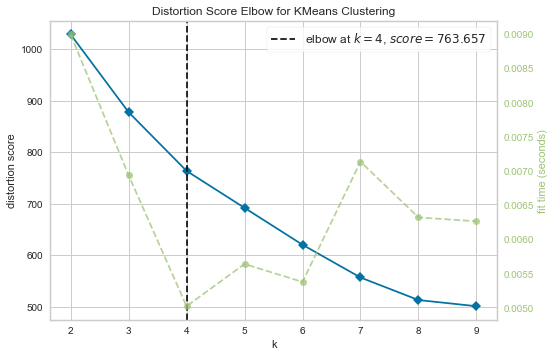

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Nombre de groupes
n = 3

km = KMeans(
    n_clusters= n, init='random',
    n_init=10, max_iter=300, 
    tol=1e-05, random_state=0
)

y_km = km.fit_predict(df_prm_scaled)

states_A, states_B, states_C, states_D = [], [], [], []
states_A_names, states_B_names, states_C_names, states_D_names = [], [], [], []
for i in range(len(states)):
    if y_km[i] == 0:
        states_A_names.append(states_names[states[i]])
        states_A.append(states[i])
    elif y_km[i] == 1:
        states_B_names.append(states_names[states[i]])
        states_B.append(states[i])
    elif y_km[i] == 2 and n >= 3:
        states_C_names.append(states_names[states[i]])
        states_C.append(states[i])
    elif y_km[i] == 3 and n>= 4:
        states_D_names.append(states_names[states[i]])
        states_D.append(states[i])

group_states = {}

for X in states:
  if X in states_A:
    group_states[X] = 'A'
  if X in states_B:
    group_states[X] = 'B'
  if X in states_C:
    group_states[X] = 'C'
  if X in states_D:
    group_states[X] = 'D'

print(states_A_names, len(states_A_names))
print(states_B_names, len(states_B_names))
print(states_C_names, len(states_C_names))
print(states_D_names, len(states_D_names))

# Elbow method K-means
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(df_prm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [29]:
target_states = {'A': [], 'B': [], 'C':[], 'D':[]}
control_states = {'A': [], 'B': [], 'C':[], 'D':[]}

for X in states:
    if X in states_A and X in target_states_all:
        target_states['A'].append(X)
    elif X in states_A and X not in target_states_all:
        control_states['A'].append(X)
    elif X in states_B and X in target_states_all:
        target_states['B'].append(X)
    elif X in states_B and X not in target_states_all:
        control_states['B'].append(X)
    elif X in states_C and X in target_states_all:
        target_states['C'].append(X)
    elif X in states_C and X not in target_states_all:
        control_states['C'].append(X)
    elif X in states_D and X in target_states_all:
        target_states['D'].append(X)
    elif X in states_D and X not in target_states_all:
        control_states['D'].append(X)



print("Number of potential target states in group A = " + str(len(target_states['A'])) + "/" + str(len(states)))
print("Number of control states in group A = " + str(len(control_states['A'])) + "/" + str(len(states)))
print("Number of potential target states in group B = " + str(len(target_states['B'])) + "/" + str(len(states)))
print("Number of control states in group B = " + str(len(control_states['B'])) + "/" + str(len(states)))
print("Number of potential target states in group C = " + str(len(target_states['C'])) + "/" + str(len(states)))
print("Number of control states in group C = " + str(len(control_states['C'])) + "/" + str(len(states)))
print("Number of potential target states in group D = " + str(len(target_states['D'])) + "/" + str(len(states)))
print("Number of control states in group D = " + str(len(control_states['D'])) + "/" + str(len(states)))

Number of potential target states in group A = 10/49
Number of control states in group A = 9/49
Number of potential target states in group B = 6/49
Number of control states in group B = 14/49
Number of potential target states in group C = 2/49
Number of control states in group C = 8/49
Number of potential target states in group D = 0/49
Number of control states in group D = 0/49


Pourcentage des états ayant voté Trump en 2016 dans le groupe A: 10.526315789473685%
Pourcentage des états ayant voté Trump en 2016 dans le groupe B: 60.0%
Pourcentage des états ayant voté Trump en 2016 dans le groupe C: 90.0%
Pourcentage des états ayant voté Trump en 2016 dans le groupe D: nan%


<ipython-input-30-b653bcef9b39>:39: RuntimeWarning:

invalid value encountered in double_scalars



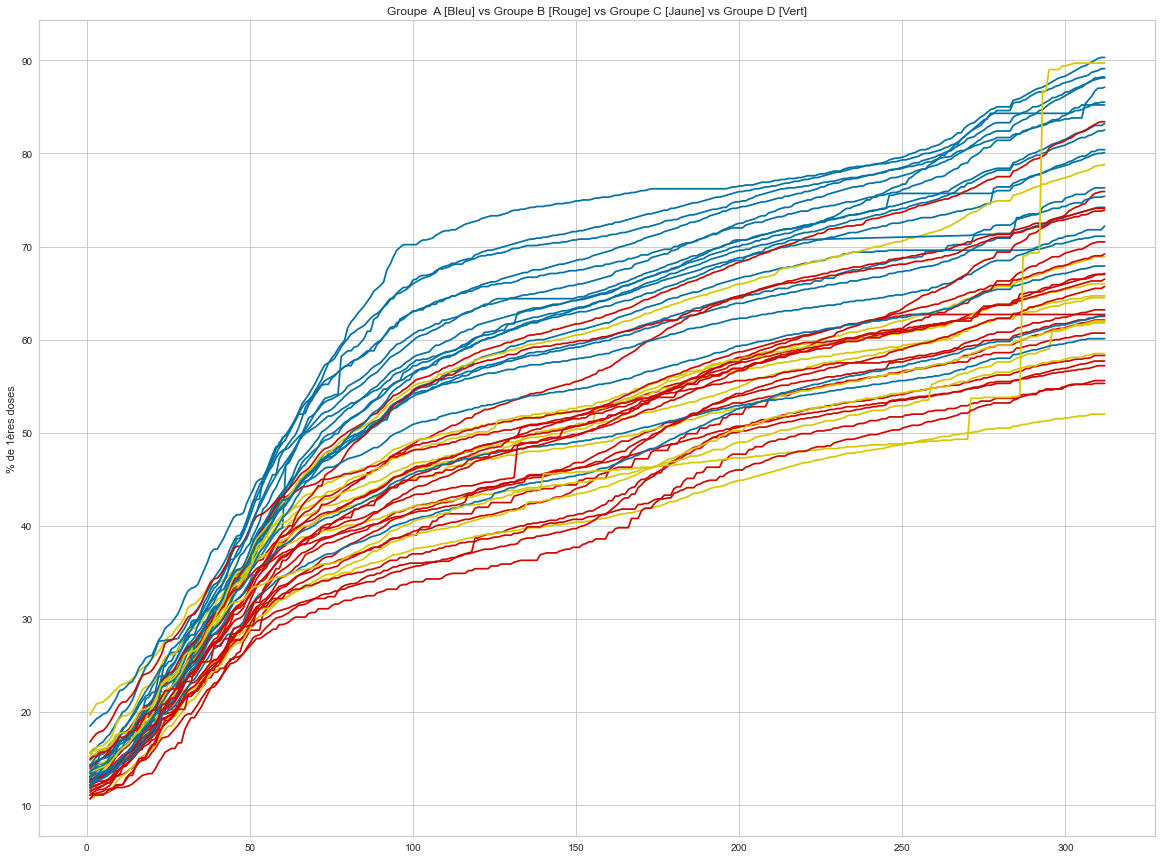

In [30]:
# Interprétation des groupes
# Remarque: même en supprimant les paramètres "politiques" (vote Trump 2020, 2016, ...)
#           le clustering génère les mêmes groupes. 

import matplotlib.pyplot as plt

vote_A, vote_B, vote_C, vote_D = [], [], [], []
states_A = np.concatenate((target_states['A'], control_states['A']))
states_B = np.concatenate((target_states['B'], control_states['B']))
states_C = np.concatenate((target_states['C'], control_states['C']))
states_D = np.concatenate((target_states['D'], control_states['D']))

for X in states_A:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_A.append(1)
    else:
        vote_A.append(0)       
pct_A = 100*np.sum(vote_A)/len(vote_A)

for X in states_B:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_B.append(1)
    else:
        vote_B.append(0)
pct_B = 100*np.sum(vote_B)/len(vote_B)

for X in states_C:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_C.append(1)
    else:
        vote_C.append(0)
pct_C = 100*np.sum(vote_C)/len(vote_C)

for X in states_D:
    if df_prm.loc[X, "2016 Trump vote"] >= 0.5:
        vote_D.append(1)
    else:
        vote_D.append(0)
pct_D = 100*np.sum(vote_D)/len(vote_D)
        
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe A: "+str(pct_A)+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe B: "+str(np.round(pct_B,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe C: "+str(np.round(pct_C,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe D: "+str(np.round(pct_D,2))+"%")

plt.figure(figsize=(20,15))
for X in states:
    c = 0
    if X in states_A:
        c = 'b'
    elif X in states_B:
        c = 'r'
    elif X in states_C:
        c = 'y'
    elif X in states_D:
        c = 'g'

    t = np.linspace(1,len(ls_dose1[X]), len(ls_dose1[X]))
    plt.plot(t, ls_dose1[X], color=c)
    
plt.ylabel('% de 1ères doses')
plt.title('Groupe  A [Bleu] vs Groupe B [Rouge] vs Groupe C [Jaune] vs Groupe D [Vert]')
plt.show()


# Carte 
import plotly.express as px

c_list = []
for X in states:
    if X in states_A:
        c_list.append(1)
    elif X in states_B:
        c_list.append(2)
    elif X in states_C:
        c_list.append(3)
    elif X in states_D:
        c_list.append(4)    
    
fig = px.choropleth(locations=states, locationmode="USA-states", color=c_list, scope="usa")
fig.show()

### Logistic regression

Alabama


<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



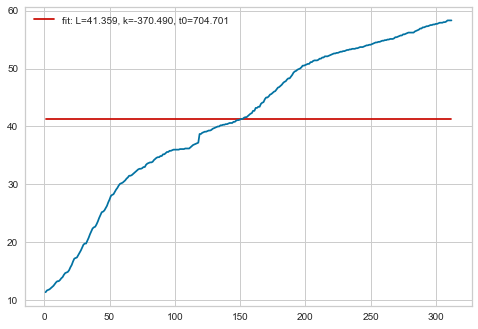

Arkansas


<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



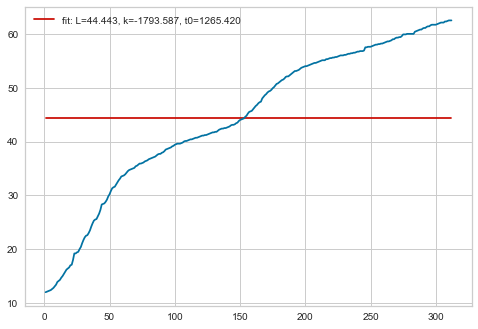

California


<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp



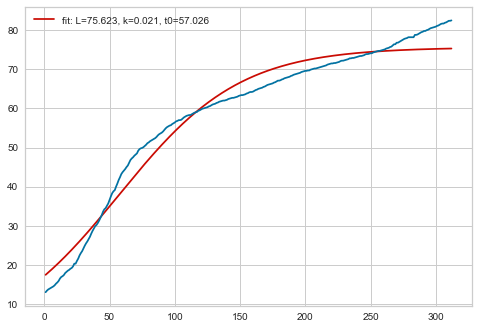

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Colorado


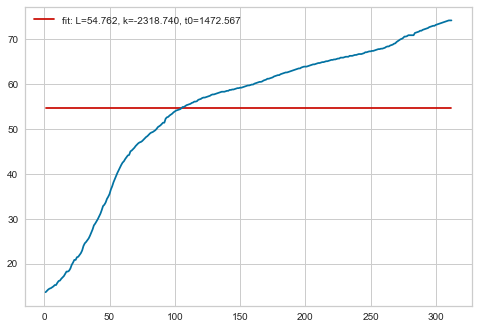

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Connecticut


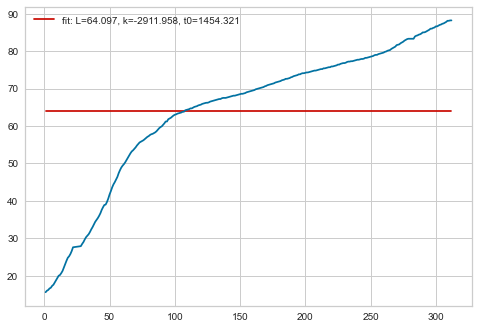

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp



Delaware


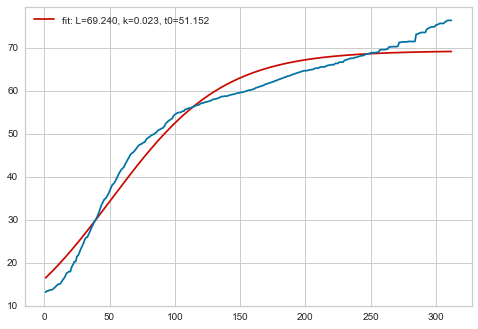

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Illinois


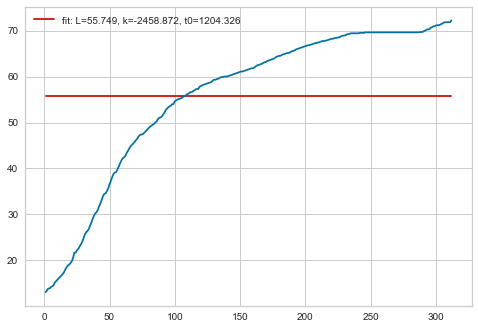

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Idaho


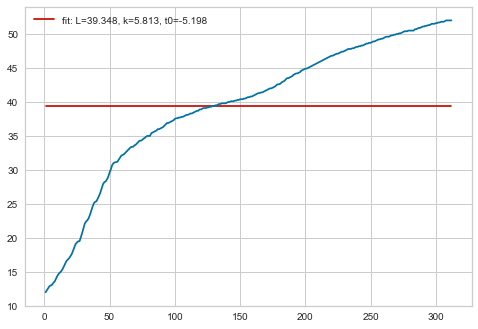

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Kentucky


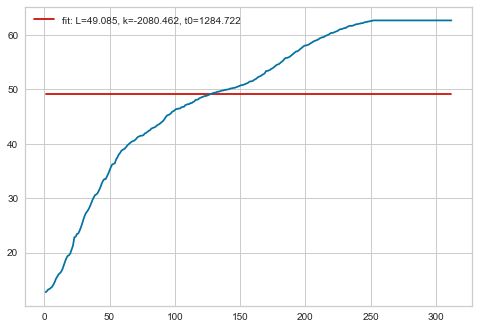

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp



Maine


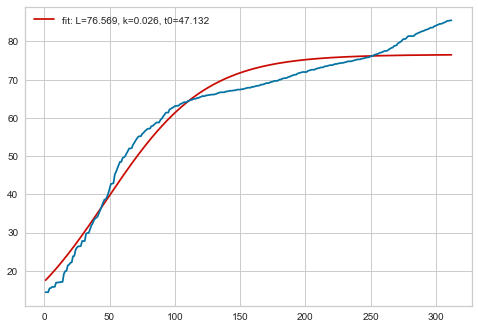

Maryland


<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp



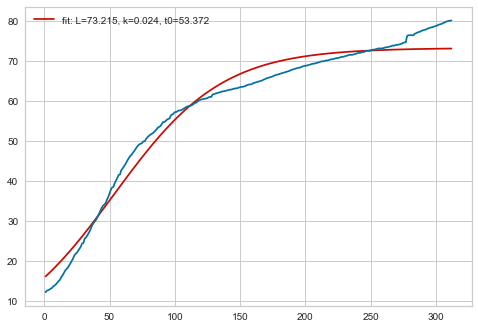

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Michigan


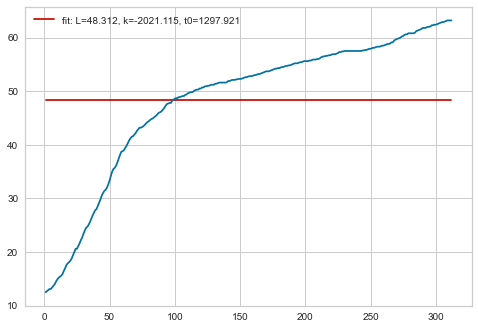

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Minnesota


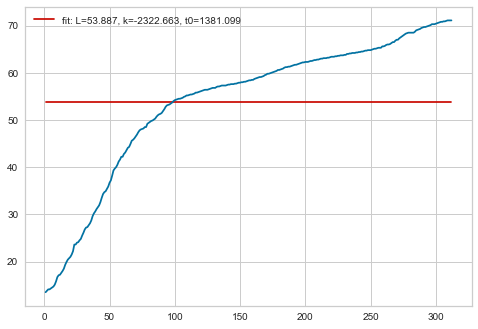

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp



New Jersey


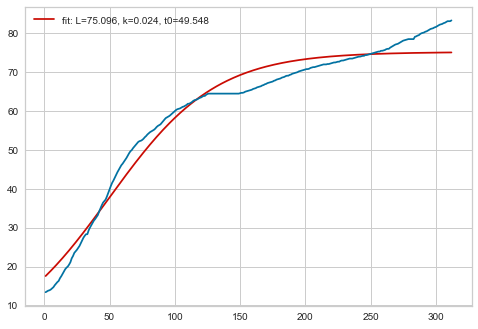

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



New York


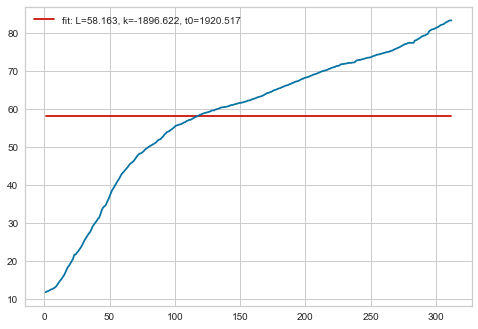

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Ohio


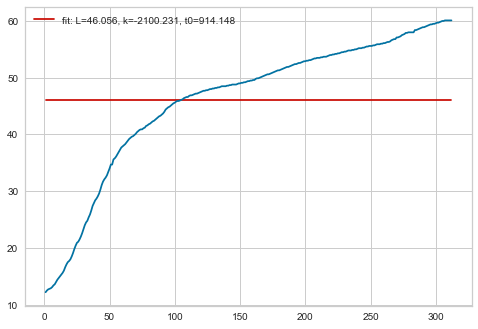

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp



Oregon


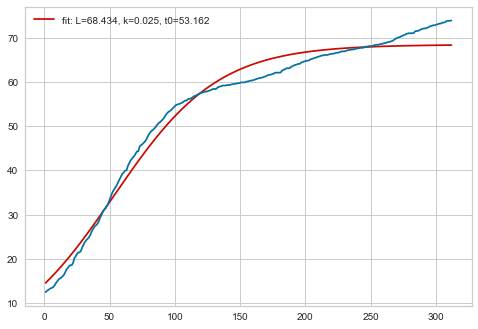

<ipython-input-17-499cceeb76e4>:6: RuntimeWarning:

overflow encountered in exp

/Users/tdepomereu/miniforge3/envs/my-env/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



West Virginia


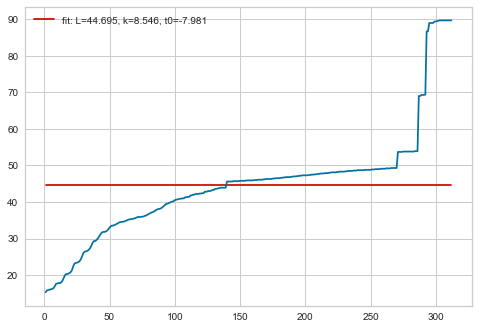

In [17]:
from scipy.optimize import curve_fit

for X in target_states_all:
  tspan = np.linspace(1,len(ls_dose1[X]), len(ls_dose1[X]))
  def func(t, L, k, tc):
    return L/(1+np.exp(-k*(t-tc)))

  popt, pcov = curve_fit(func, tspan, ls_dose1[X])
  print(states_names[X])
  plt.plot(tspan, func(tspan, *popt), 'r-', label='fit: L=%5.3f, k=%5.3f, t0=%5.3f' % tuple(popt))
  plt.plot(tspan, ls_dose1[X], 'b-')
  plt.legend()
  plt.show()

# 


## 2. Analyse en composantes principales
### Indépendant du synthetic control

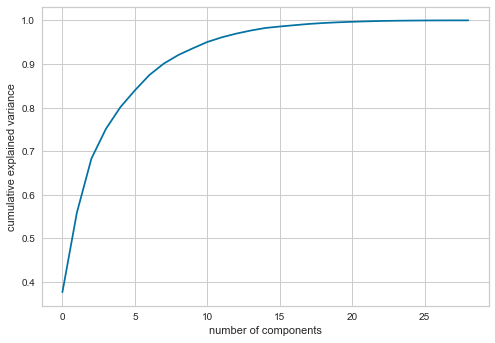

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(df_prm_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Text(0, 0.5, 'Percent Variance Explained')

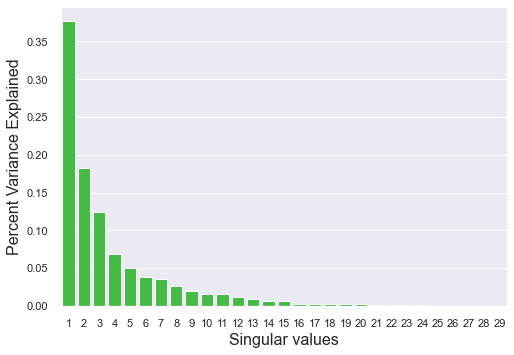

In [19]:
u, s, v = np.linalg.svd(df_prm_scaled, full_matrices=True)

v10 = v[:5,:]

var_explained = np.round(s**2/np.sum(s**2), decimals=3)
var_explained

import seaborn as sns; sns.set()
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen")
plt.xlabel('Singular values', fontsize=16)
plt.ylabel('Percent Variance Explained', fontsize=16)

In [20]:
prm_scaled_t = np.transpose(prm_scaled)
prm_pca = np.transpose(np.dot(v10, prm_scaled_t))

state_vector_pca = {}
for i in range(len(states)):
    state_vector_pca[states[i]] = prm_pca[i]

# 

## 3. Retour au synthetic control

In [21]:
def norm(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.dot(pred_diff, pred_diff_v)
    return np.sqrt(res)

def mspe(y1, y, w):
    interv = np.dot(np.transpose(y), w)
    interv_diff = y1 - interv
    res = np.dot(interv_diff, interv_diff)
    return res

In [22]:
# Définition des fonctions d'optimisation pour le contrôle synthétique

from scipy.optimize import minimize, fmin_slsqp

def constraint(w, v, x, x1):
    return np.sum(w) - 1

def con(v):
    return np.sum(v) - 1
cons = {'type':'eq', 'fun': con}

def mspe_opt_w(v_guess, w_guess, x, x1, y, y1):
    w_opt = fmin_slsqp(norm, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v_guess, x, x1), disp=False)
    return mspe(y1, y, w_opt)

def opt_v(v_guess, w_guess, x, x1, y, y1):
    v_opt = minimize(mspe_opt_w, v_guess, constraints = cons, bounds=[(0.0, 1.0)]*len(v_guess), 
             args=(w_guess, x, x1, y, y1))
    return v_opt.x

def opt_w(w_guess, v, x, x1):
    w_opt = fmin_slsqp(norm, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v, x, x1), disp=False)
    return w_opt

In [23]:
# Définition des dates de début des incentives par état

import datetime

inc_t0 = {}

for X in target_states_all:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates[X]
  t0_date = datetime.date(int(t0_date_str[:4]), int(t0_date_str[5:7]), int(t0_date_str[9:]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0[X] = t0

In [24]:
# Contrôle synthétique

y1_prediction = {}

dfs={}
dfs['A'] = pd.DataFrame(columns=control_states['A'])
dfs['B'] = pd.DataFrame(columns=control_states['B'])
dfs['C'] = pd.DataFrame(columns=control_states['C'])
dfs['D'] = pd.DataFrame(columns=control_states['D'])

def synthetic(ls_dose, state_vector, t_fit, plot=True):
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")

  for Y in target_states_all:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target],group_states[X_target], 'is simulated with:')
      
      t0 = inc_t0[X_target]
      
      if X_target in states_A:
          L = 'A'
      elif X_target in states_B:
          L = 'B'
      elif X_target in states_C:
          L = 'C'
      elif X_target in states_D:
          L = 'D'
      
      y1 = ls_dose1[X_target][t0-t_fit:t0]
      y = []
      for X in control_states_all:    
          y.append(ls_dose1[X][t0-t_fit:t0])

      y_post = []
      for X in control_states_all:    
          y_post.append(ls_dose1[X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_states_all :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      w_guess = np.array([1/k]*k)
      v_guess = np.array([1/j]*j)


      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)
      V.append(np.concatenate(([L], np.round(v_star, 3))))
      
      

      y1_prediction[X_target] = np.dot(np.transpose(y_post), w_star)
      
      df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_states_all)

      dfs[L]= pd.concat([dfs[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_states_all[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],group_states[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[X_target]), len(ls_dose1[X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(states_names[X_target]+ ' (Groupe '+L+' | Category '+str(category[X_target])+')')


        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom] (Groupe '+L+' | Category '+str(category[X_target])+')')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_states_all:
            if X != X_target:
                plt.plot(t, ls_dose1[X], 'b--', linewidth=0.5)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        plt.subplot(2, 2, 4) # row 1, col 2 index 1
        for i in range(len(control_states_all)):
            X = control_states_all[i]
            if X != X_target:
              if X in control_states[L]:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'g', linewidth=th)
              else:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'r', linewidth=th)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvline(x=t0-t_fit, ls='dotted', label= "début du fit")
        plt.legend()
        plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')
  return V

Les poids des différents états de contrôle dans le synthetic control: 

The state of Alabama B is simulated with:
    Mississippi B 52.2 %
    Tennessee C 42.3 %
    Indiana B 5.6000000000000005 %


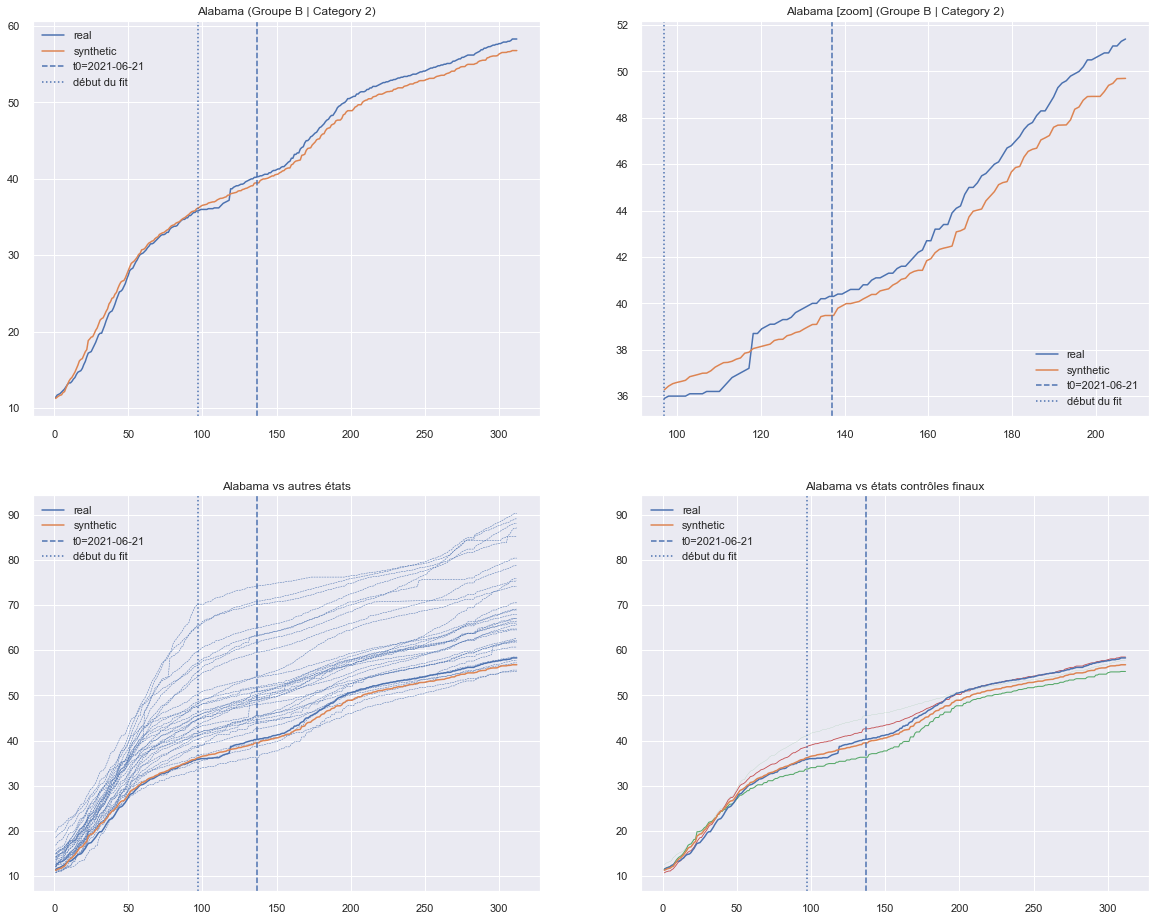


The state of Arkansas B is simulated with:
    Texas B 36.0 %
    Mississippi B 27.200000000000003 %
    Wyoming B 23.0 %
    Alaska C 5.4 %
    Virginia C 4.3 %
    Tennessee C 4.0 %


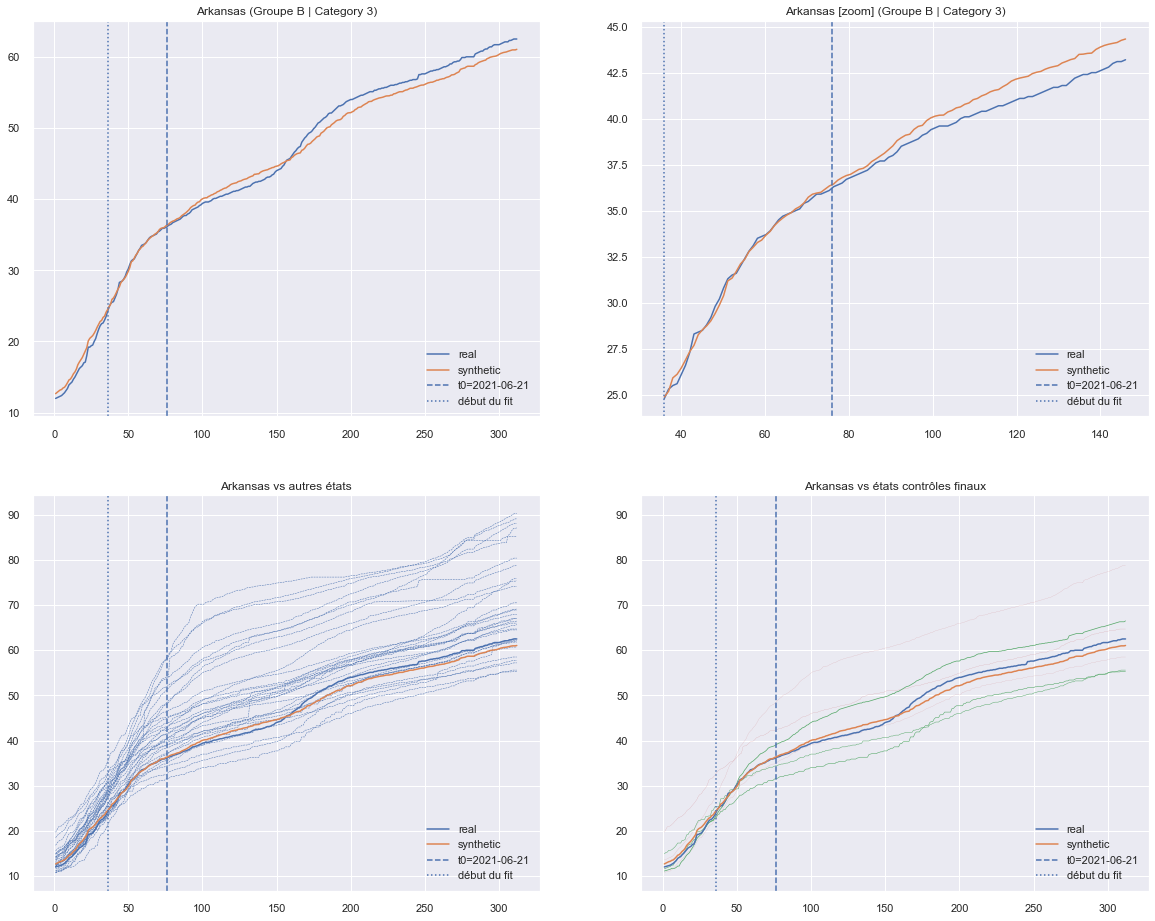


The state of California A is simulated with:
    Massachusetts A 51.800000000000004 %
    Utah B 34.300000000000004 %
    Wisconsin A 6.2 %
    Nevada B 4.9 %
    Hawaii A 2.8000000000000003 %


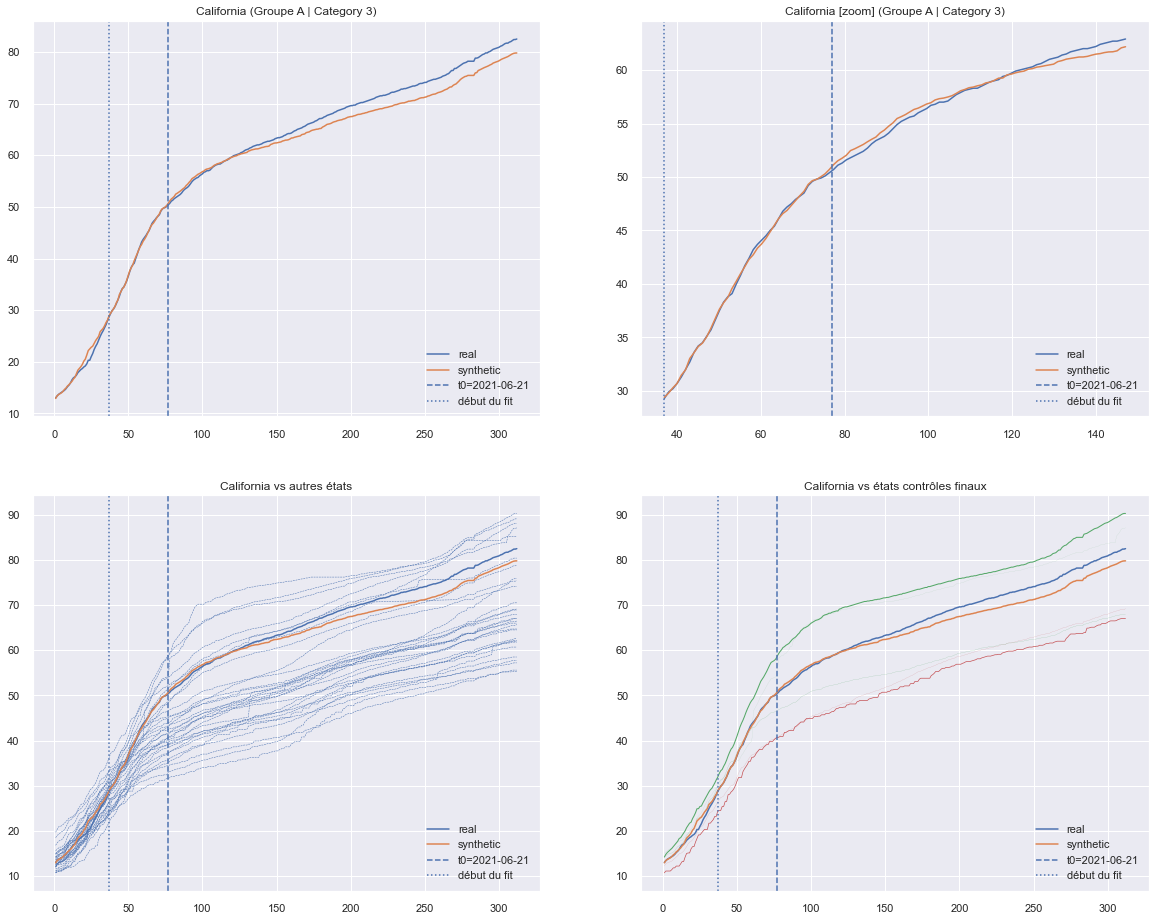


The state of Colorado A is simulated with:
    Wisconsin A 25.2 %
    Vermont A 25.2 %
    Virginia C 25.0 %
    Louisiana B 24.5 %


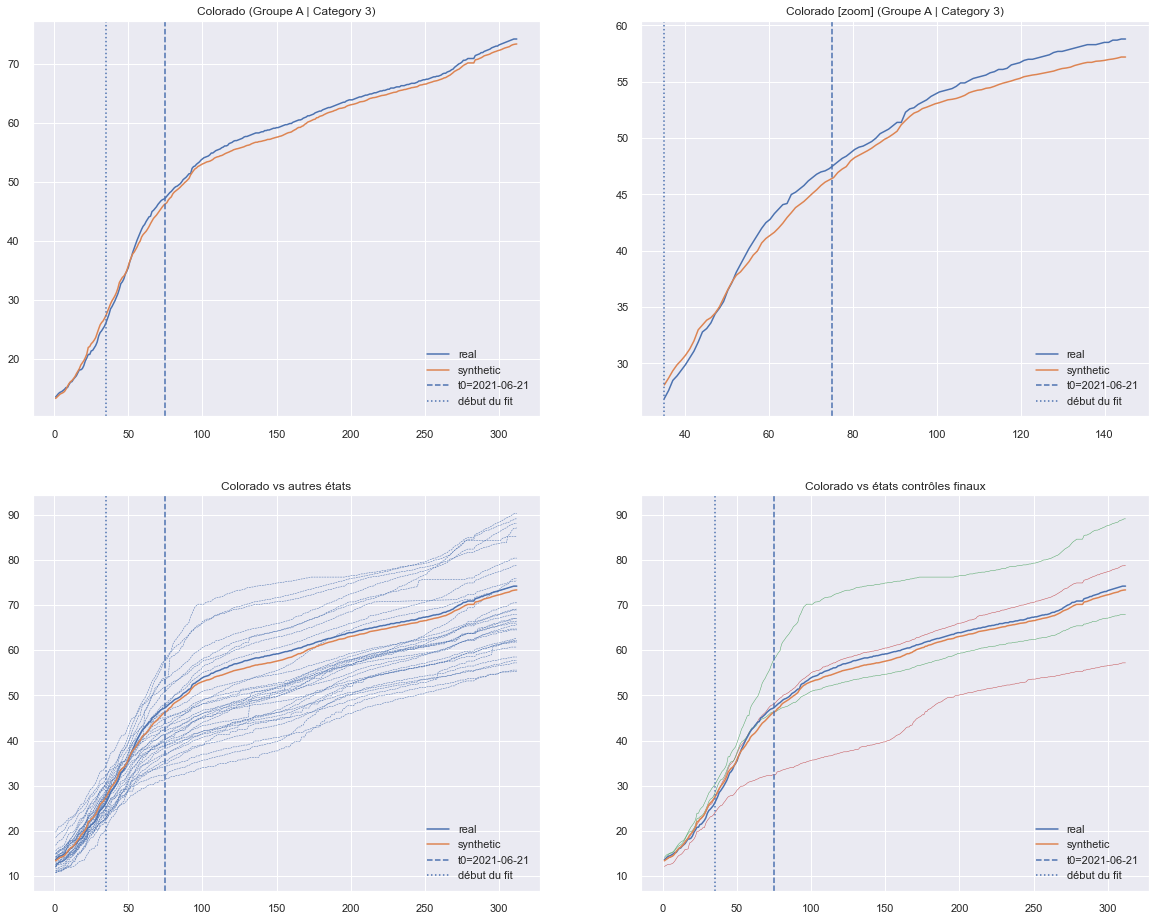


The state of Connecticut A is simulated with:
    Massachusetts A 100.0 %


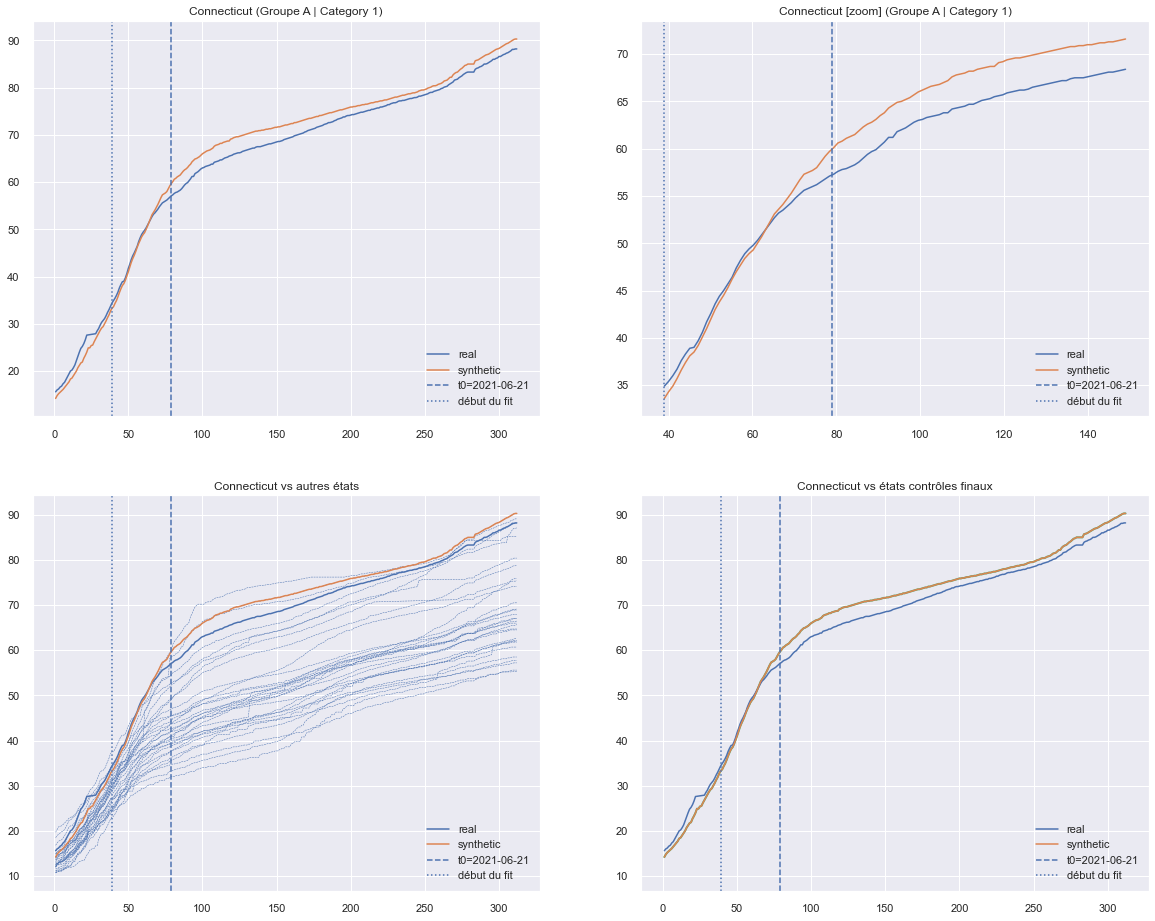


The state of Delaware A is simulated with:
    Wisconsin A 36.5 %
    Rhode Island A 17.599999999999998 %
    Vermont A 15.5 %
    Missouri B 12.2 %
    South Carolina A 10.4 %
    Virginia C 3.0 %
    New Mexico A 2.0 %
    Washington A 1.7999999999999998 %


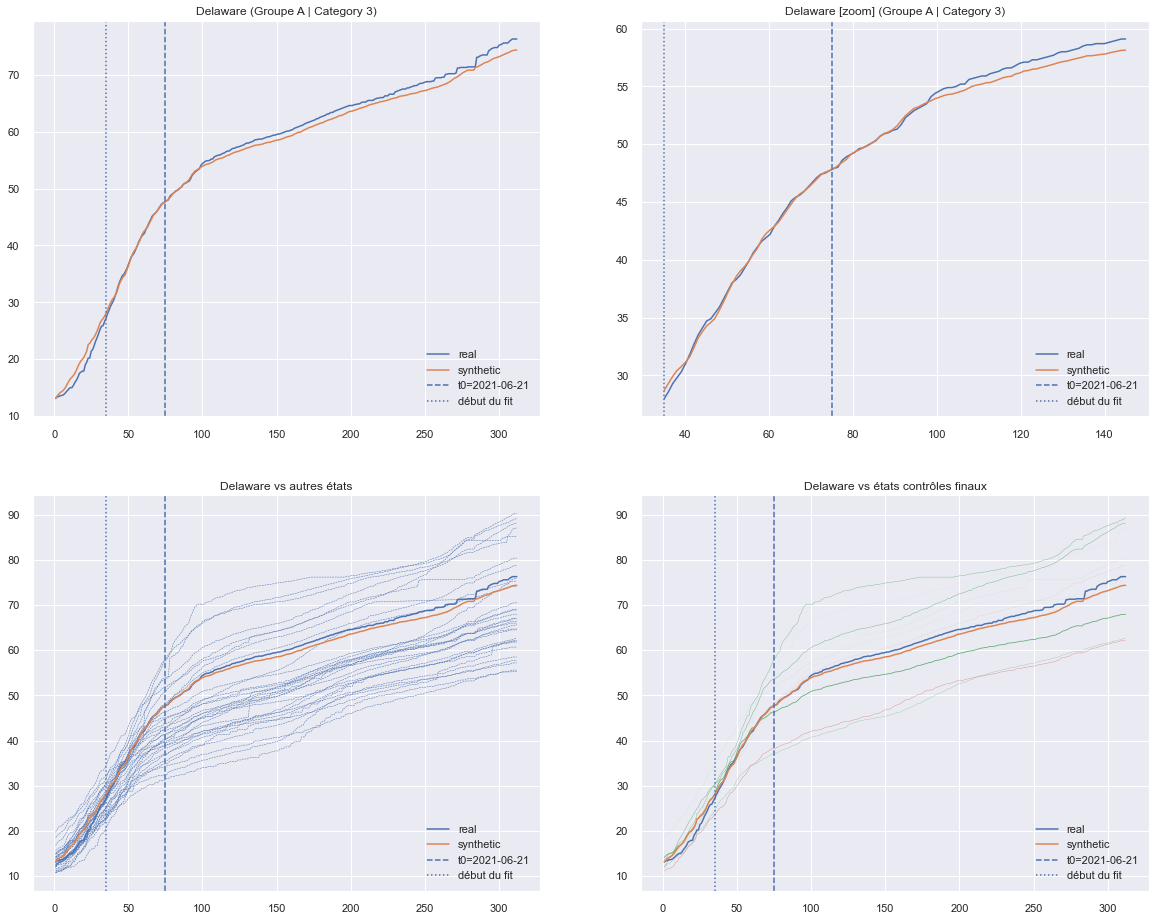


The state of Illinois A is simulated with:
    Nevada B 35.0 %
    Rhode Island A 26.700000000000003 %
    Hawaii A 19.0 %
    Utah B 10.7 %
    New Mexico A 8.0 %


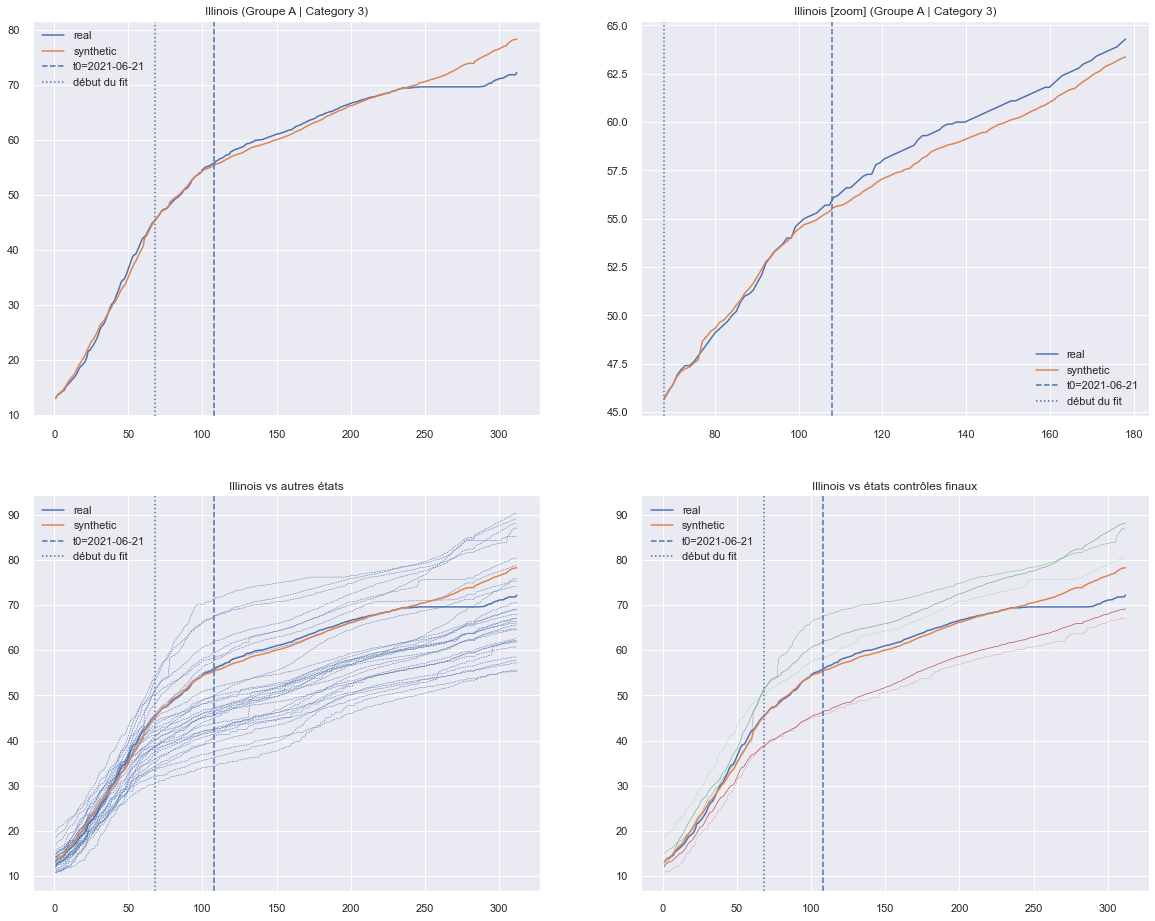


The state of Idaho C is simulated with:
    Tennessee C 48.5 %
    Mississippi B 25.2 %
    North Dakota C 15.299999999999999 %
    Virginia C 8.5 %
    Utah B 2.5 %


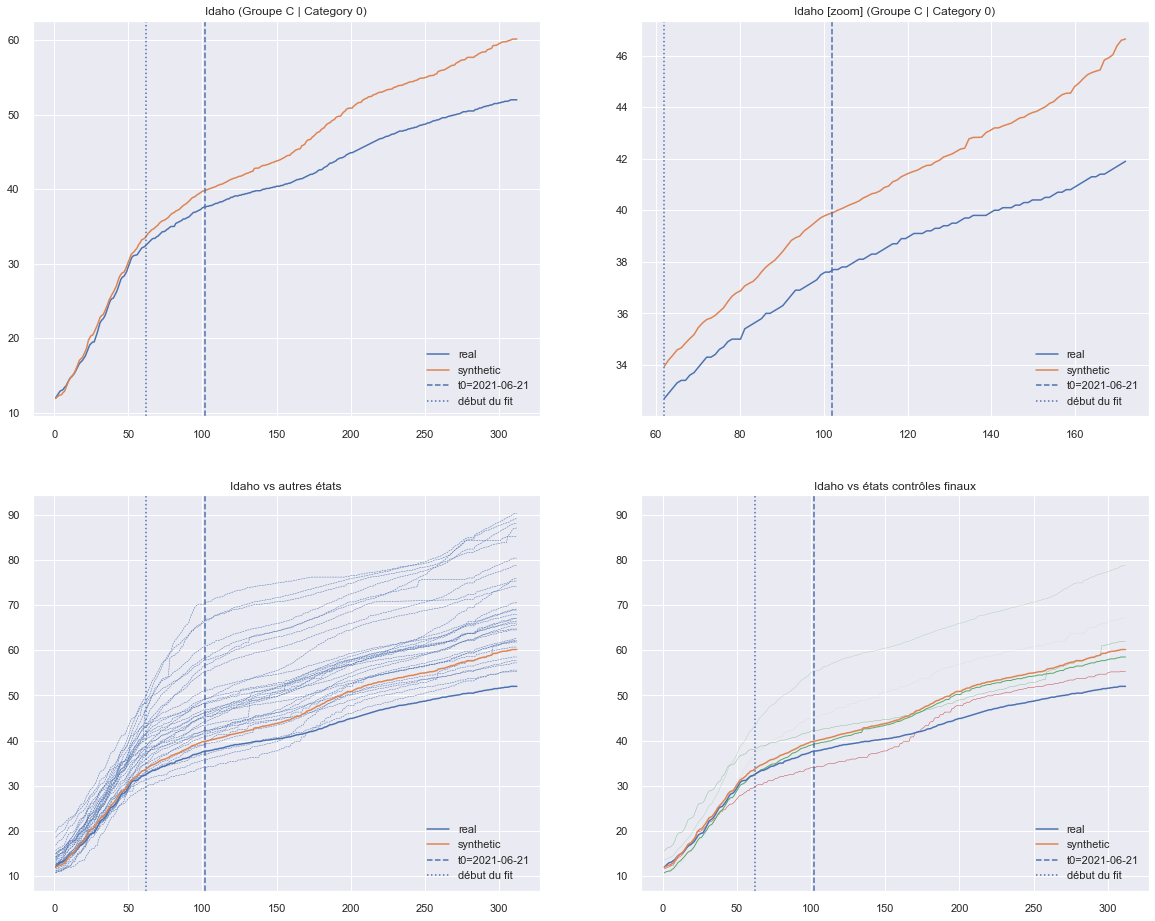


The state of Kentucky B is simulated with:
    Iowa C 34.4 %
    Wyoming B 21.8 %
    Alaska C 18.6 %
    Washington A 14.399999999999999 %
    Louisiana B 7.3 %
    Virginia C 3.5000000000000004 %


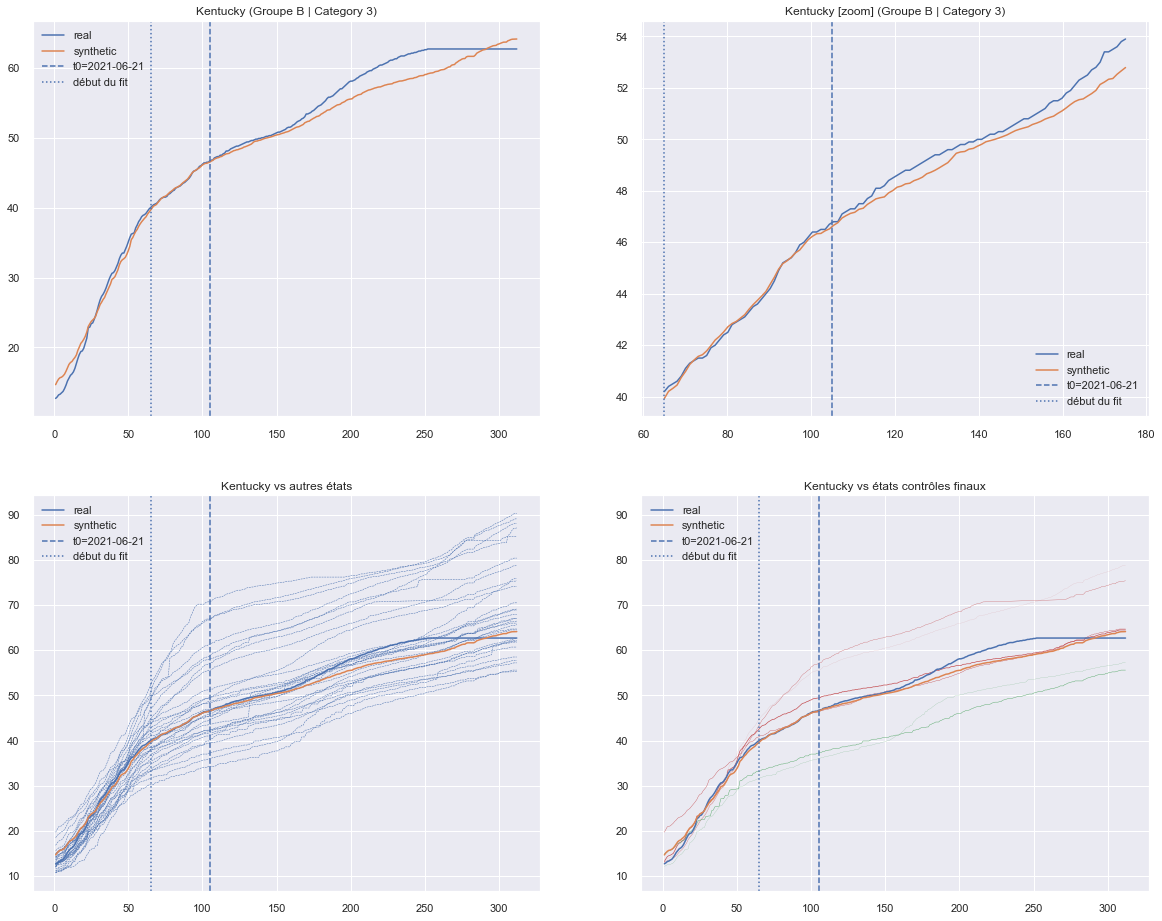


The state of Maine A is simulated with:
    Rhode Island A 88.3 %
    Washington A 11.700000000000001 %


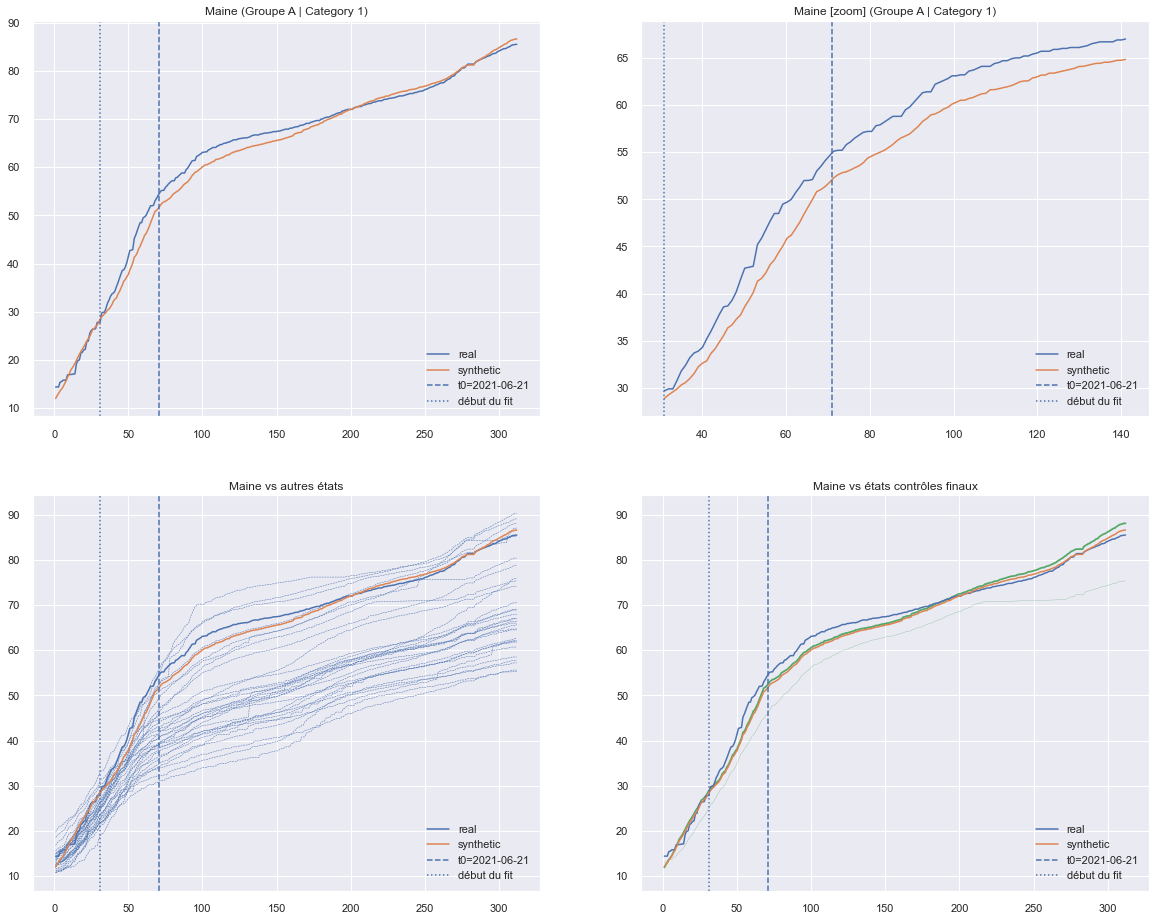


The state of Maryland A is simulated with:
    Massachusetts A 49.0 %
    Georgia B 32.6 %
    New Mexico A 12.1 %
    Hawaii A 6.2 %


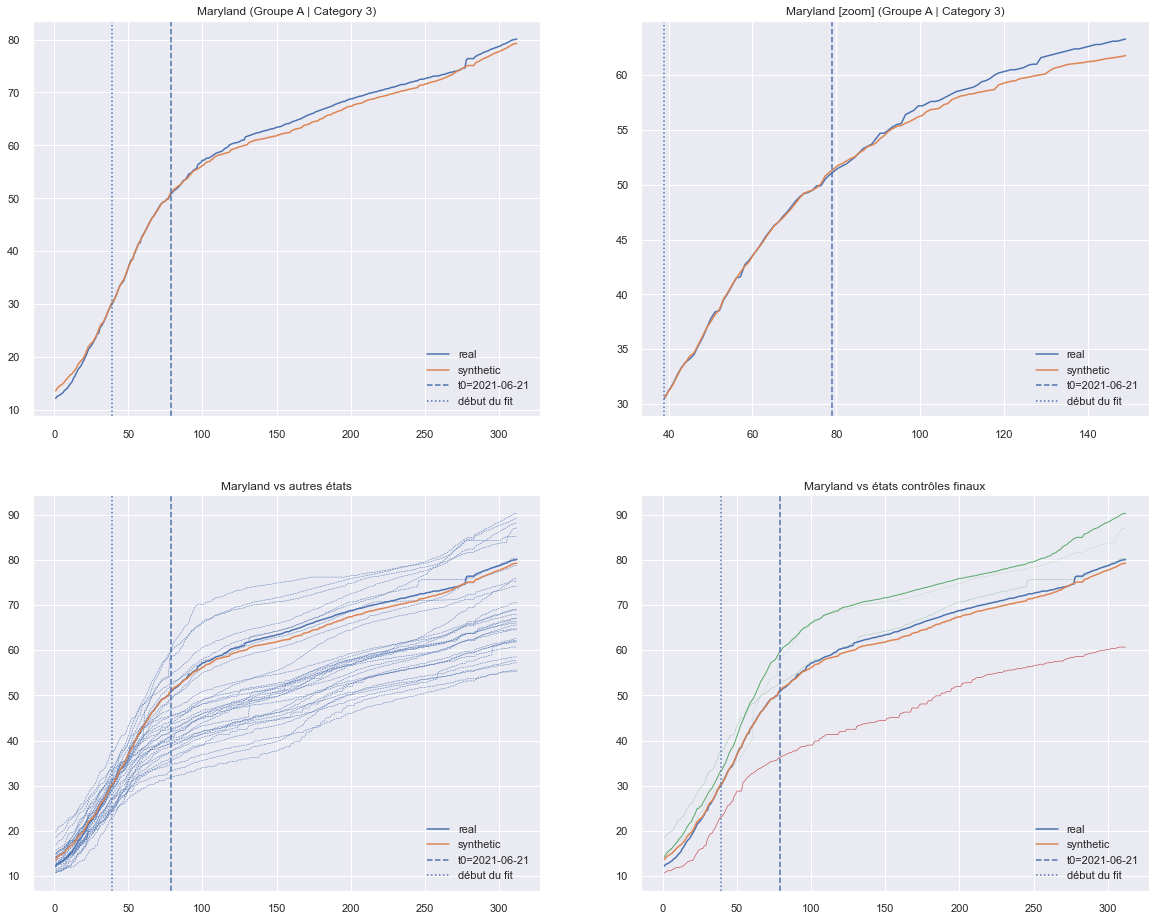


The state of Michigan B is simulated with:
    Iowa C 25.4 %
    Rhode Island A 21.7 %
    Kansas C 20.9 %
    South Carolina A 11.700000000000001 %
    Louisiana B 8.6 %
    Wyoming B 6.800000000000001 %
    Pennsylvania A 3.5000000000000004 %
    Washington A 1.5 %


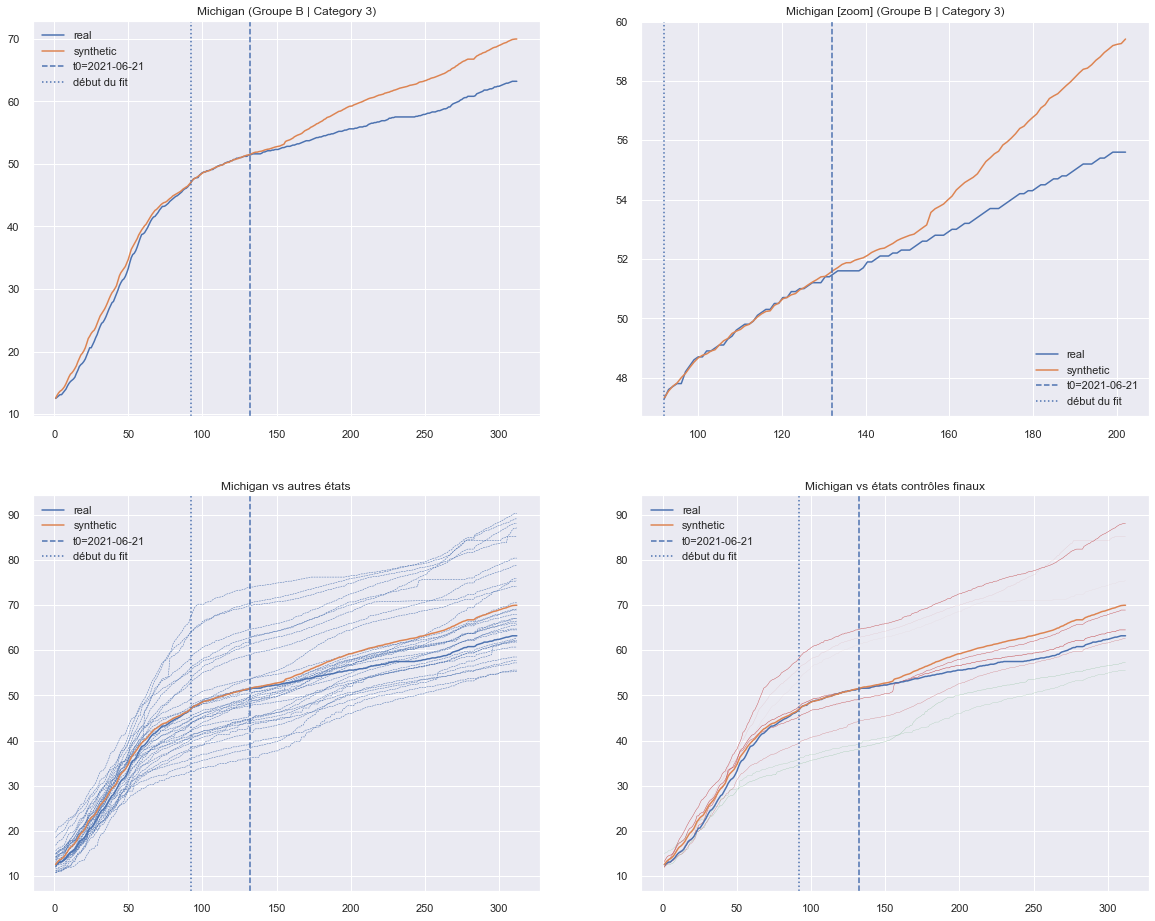


The state of Minnesota A is simulated with:
    Iowa C 30.099999999999998 %
    Massachusetts A 28.9 %
    Wisconsin A 26.1 %
    Nebraska C 9.6 %
    North Dakota C 5.4 %


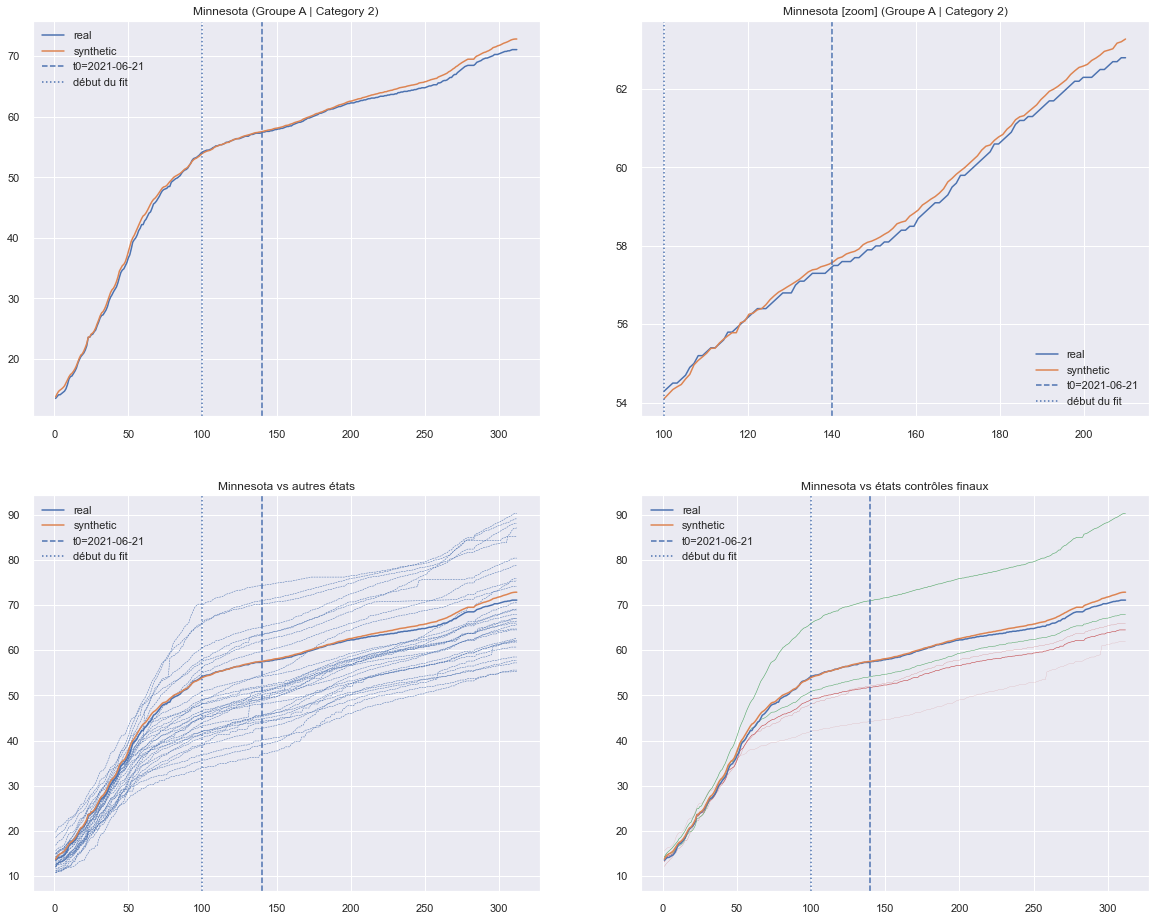


The state of New Jersey A is simulated with:
    Massachusetts A 37.5 %
    New Mexico A 28.4 %
    Washington A 19.900000000000002 %
    Vermont A 14.2 %


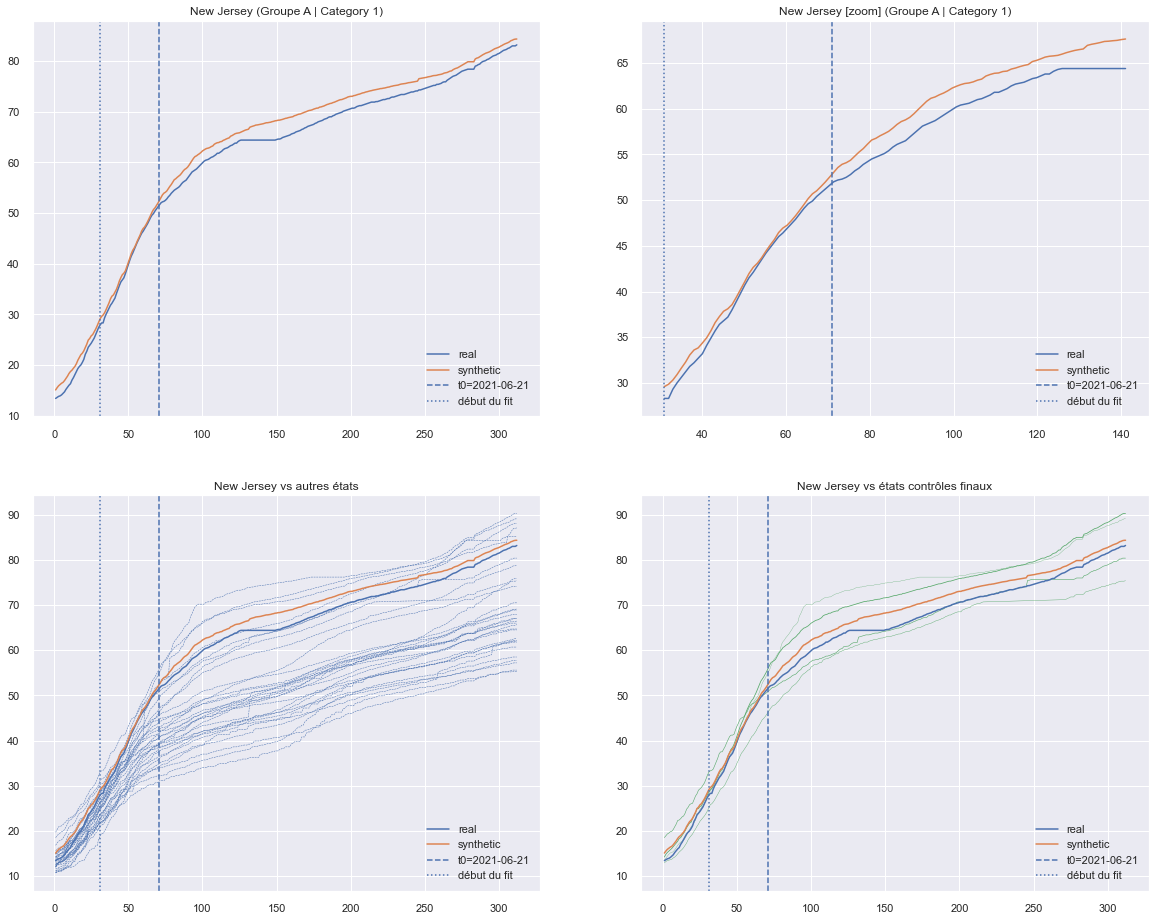


The state of New York B is simulated with:
    Rhode Island A 46.300000000000004 %
    Utah B 23.7 %
    New Mexico A 17.599999999999998 %
    Nevada B 7.9 %
    Kansas C 4.3999999999999995 %


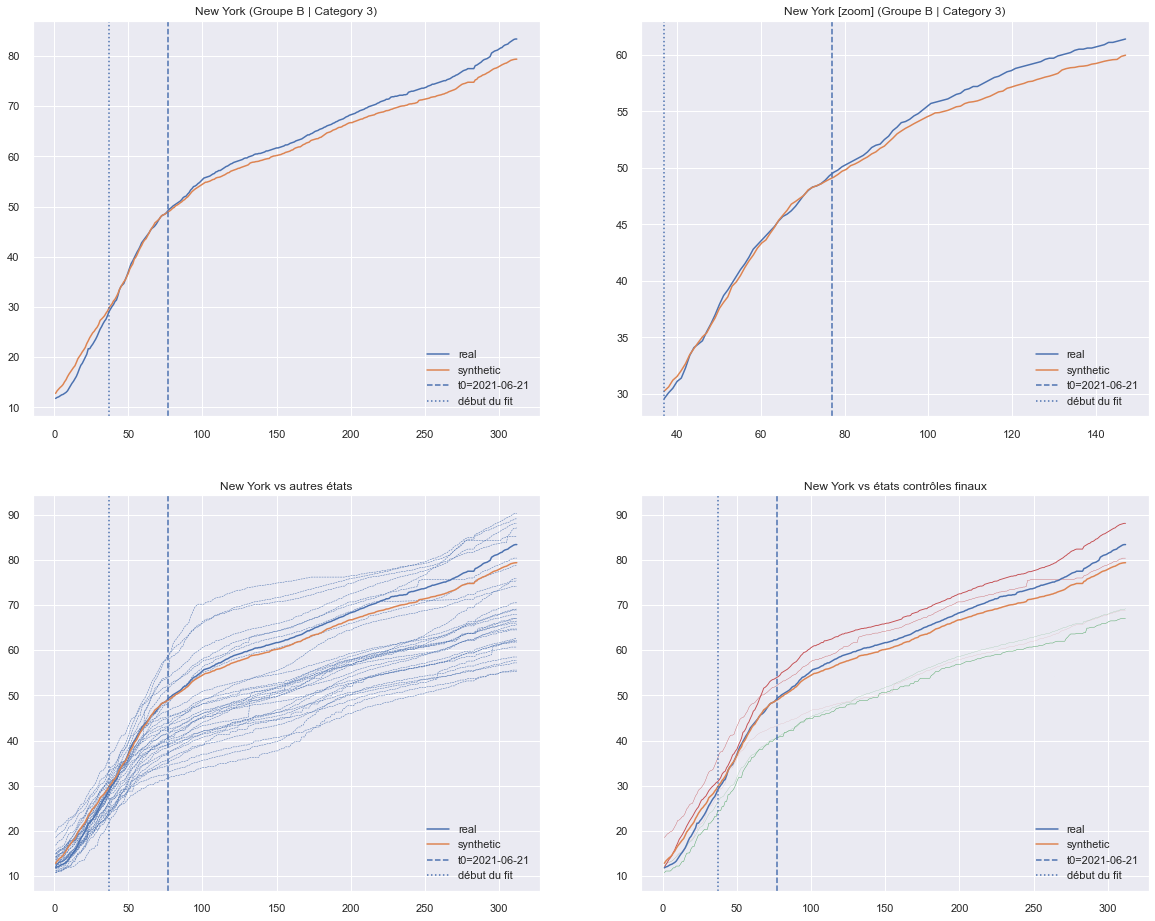


The state of Ohio A is simulated with:
    Florida B 37.6 %
    Utah B 22.400000000000002 %
    Louisiana B 17.9 %
    New Mexico A 17.2 %
    Nevada B 2.9000000000000004 %
    Hawaii A 1.7999999999999998 %


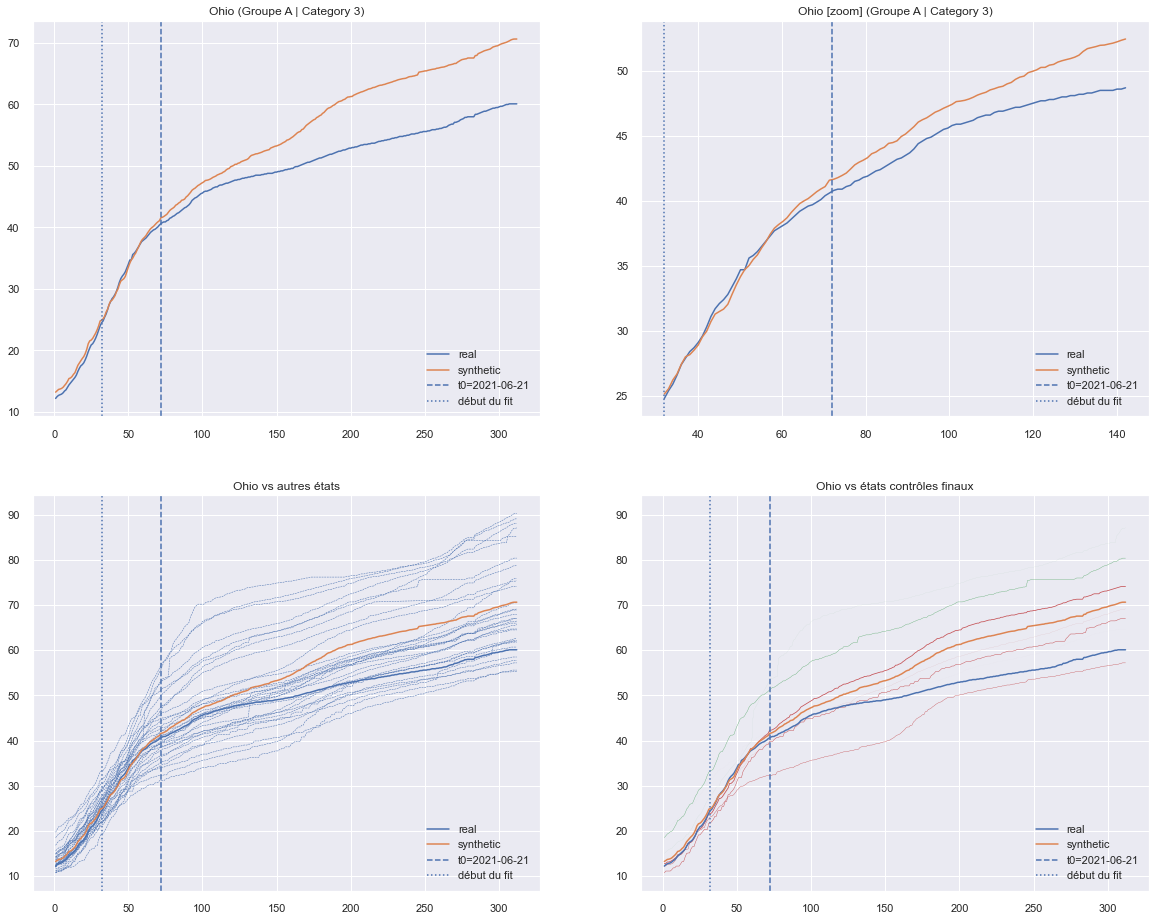


The state of Oregon B is simulated with:
    Montana C 11.200000000000001 %
    Virginia C 8.6 %
    Washington A 8.0 %
    Hawaii A 6.2 %
    Pennsylvania A 5.8999999999999995 %
    Tennessee C 5.5 %
    Nevada B 5.1 %
    North Dakota C 2.1 %
    South Dakota B 2.1 %
    Alaska C 2.1 %
    Arizona B 2.1 %
    Kansas C 2.1 %
    Massachusetts A 2.1 %
    Missouri B 2.1 %
    Utah B 2.1 %
    North Carolina B 2.1 %
    Oklahoma B 2.1 %
    Wyoming B 2.1 %
    Iowa C 2.1 %
    Nebraska C 2.1 %
    South Carolina A 2.1 %
    Indiana B 2.1 %
    Rhode Island A 2.1 %
    New Mexico A 2.1 %
    Florida B 2.1 %
    Vermont A 2.1 %
    Georgia B 2.1 %
    Louisiana B 2.1 %
    Mississippi B 2.1 %
    Texas B 2.1 %
    Wisconsin A 2.1 %


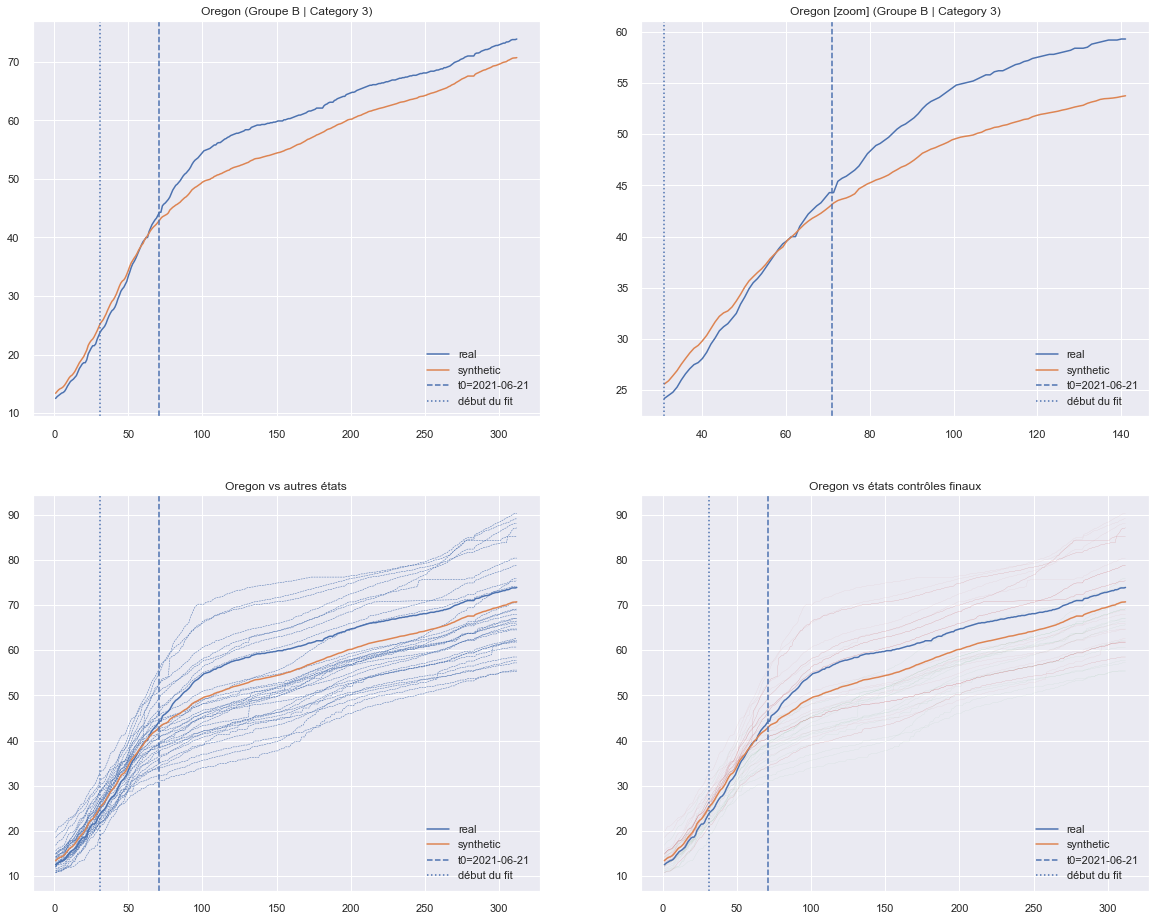


The state of West Virginia C is simulated with:
    Tennessee C 27.6 %
    Wyoming B 23.799999999999997 %
    South Carolina A 23.7 %
    Washington A 11.899999999999999 %
    Wisconsin A 9.0 %
    Indiana B 2.5 %
    Pennsylvania A 1.5 %


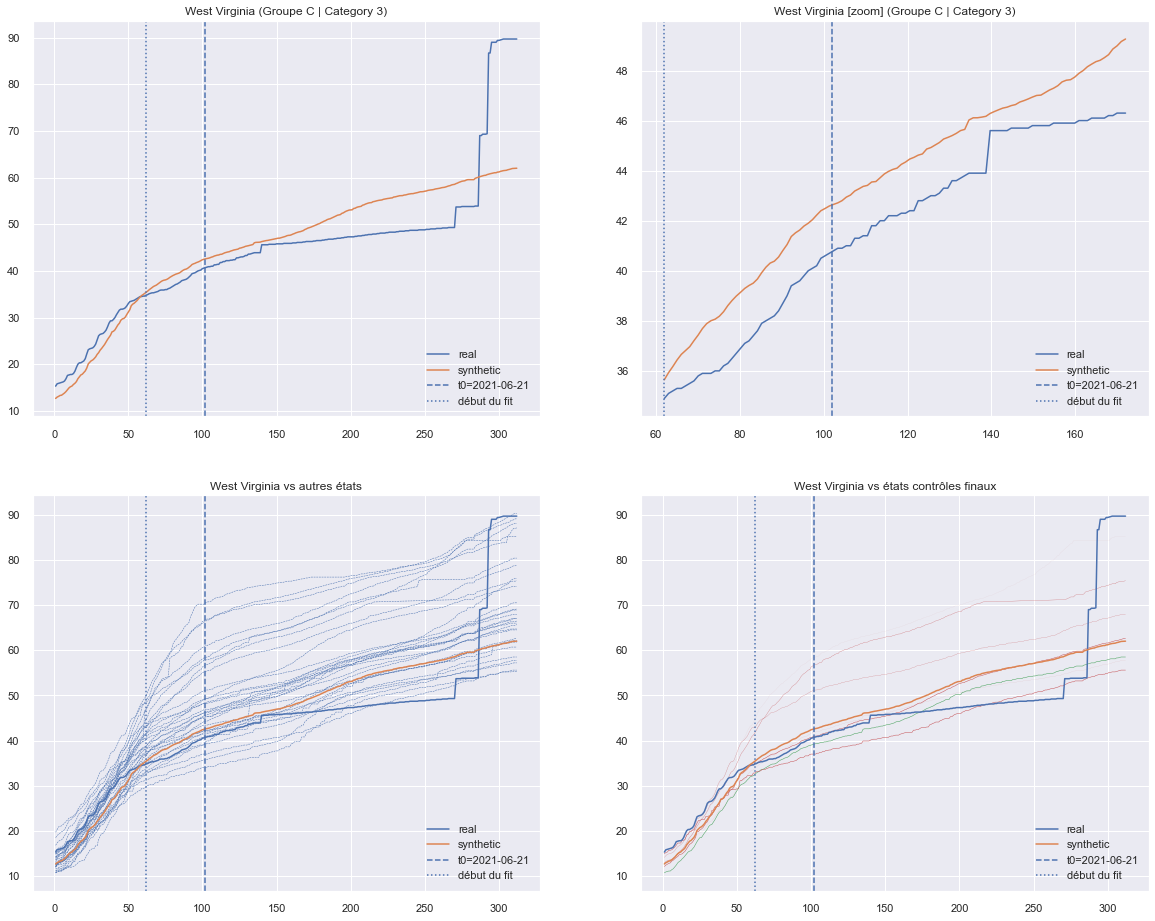

In [25]:
V = synthetic(ls_dose1, state_vector_scaled, 40)

### Analyse des résultats

In [26]:
# Delta entre pourcentage vacciné synthetic/réel intégré jusqu'à t0 Aire courbe pourcentage vacciné réel
# Proximité à 0 indique qualité du fit jusqu'à t0

from sklearn.metrics import mean_squared_error

def fit_q(ls_dose, y1_prediction, after_t0=False):
    fit_quality = []

    if after_t0 == False:
        for X in target_states_all:
            t0 = inc_t0[X]
            err = mean_squared_error(ls_dose1[X][:t0],y1_prediction[X][:t0])
            fit_quality.append(np.round(np.sqrt(err),2))
    else:
        for X in target_states_all:
            t0 = inc_t0[X]
            err = mean_squared_error(ls_dose1[X][t0+1:],y1_prediction[X][t0+1:])
            fit_quality.append(np.round(np.sqrt(err),2))

    df_fit = pd.DataFrame(fit_quality, index = target_states_all, columns=['%'])

    return df_fit

In [27]:
# CALCUL DE P-VALUE APRES JANVIER

# def p_value(ls_dose, y1_prediction):
#   p_vls = []

#   for X in target_states_all:
#     p_res = 0

#     t0 = inc_t0[X]
#     Ra = float(df_fit(ls_dose, y1_prediction).loc[[X],:])
#     Rb = float(df_fit(ls_dose, y1_prediction, True).loc[[X],:])
#     r1 = Rb/Ra

#     for Y in states:
#       t0 = inc_t0[X]
#       Ra = float(df_fit(ls_dose, y1_prediction).loc[[Y],:])
#       Rb = float(df_fit(ls_dose, y1_prediction, True).loc[[Y],:])
#       r = Rb/Ra
#       if r - r1 >= 0:
#         p_res += 1
  
#   p_vls.append(np.round(p_res/len(states),2))

In [28]:
# Delta entre pourcentage de vaccination synthétique et réel n jours après t0

time_delta = [0, 30, 60, 90]
def delta_y(ls_dose, y1_prediction):
  delta = []

  for X in target_states_all:
    t0 = inc_t0[X]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose1[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = target_states_all, columns = time_delta)


  return df_delta

In [29]:
# Analyse de l'importance respective des coefficients des paramètres V*

def important_v(V):
  poids_v = pd.DataFrame(V, index=target_states_all, columns=np.concatenate((["Groupe"], df_prm.columns)))
  poids_v1 = poids_v.drop(columns=['Groupe'])
  poids_v1 = poids_v1.astype('float64')

  
  fig, axes = plt.subplots(11, 3, figsize=(18, 50))
  j = 0
  for c in poids_v1.columns:
    var = poids_v1.loc[:,c]
    ax = sns.barplot(ax=axes[int(np.trunc(j/3)),j%3], x=target_states_all,
            y=var, color="limegreen")
    # ax.set(yscale="log")
    ax.set(ylim=(0, 1))
    j+=1
    
  v_sum = poids_v1.sum()

  print("Most important parameters \n", v_sum.sort_values(ascending=False).head(), '\n')
  print("Least important parameters \n",v_sum.sort_values(ascending=False).tail())

Most important parameters 
 2016 Trump vote                                      1.553
Over 65 years old                                    1.346
Black                                                1.294
Firearms Death Rate                                  1.266
Population density (number of people/square mile)    1.254
dtype: float64 

Least important parameters 
 Covid vax hesitancy (somewhat hesitant)    0.212
Adult obesity rate                         0.208
Asian                                      0.176
Under 18 years old                         0.164
Crime Rate                                 0.123
dtype: float64


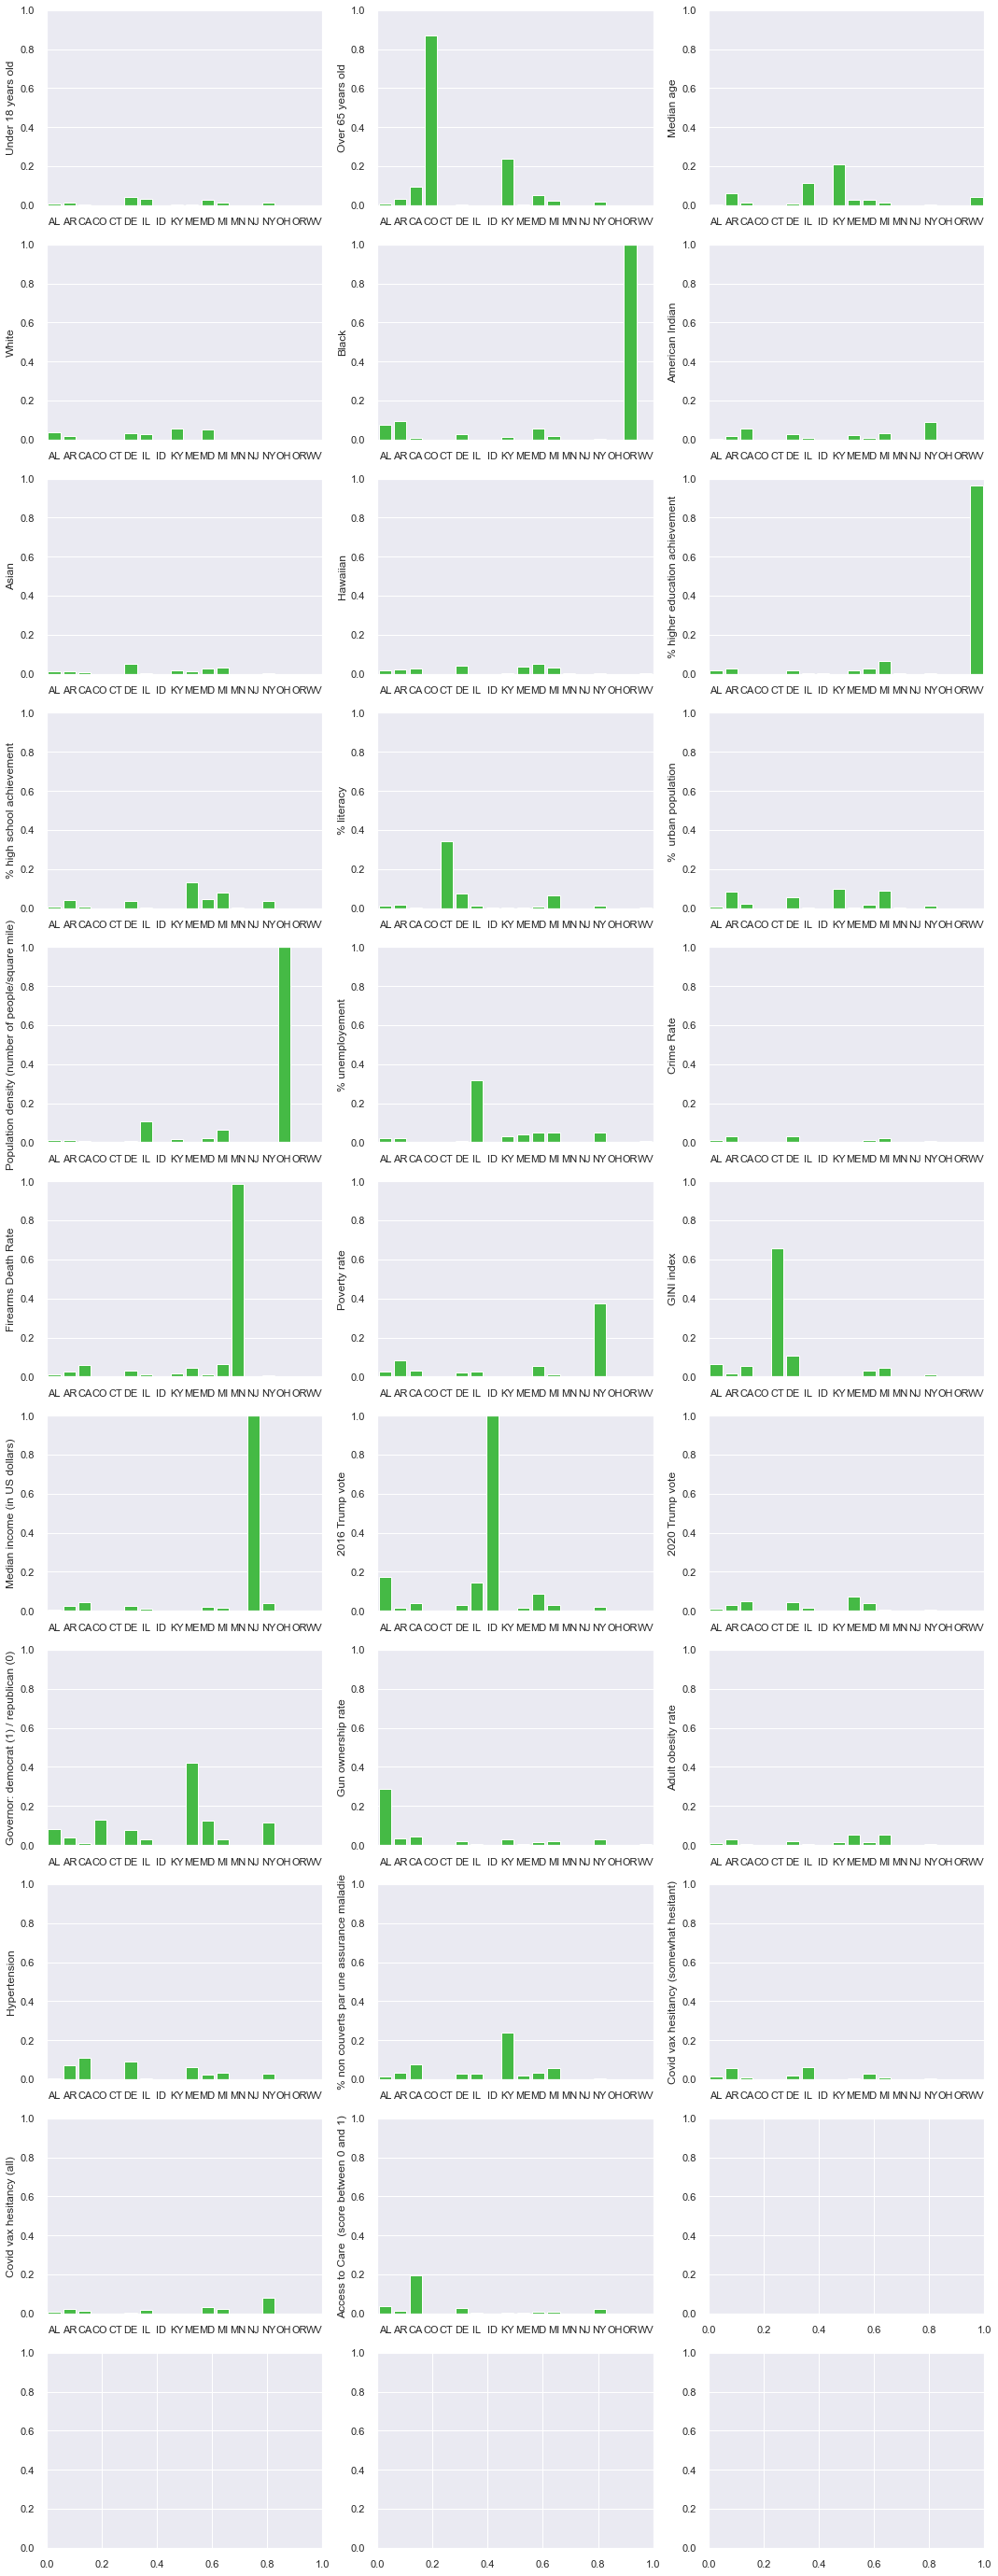

In [30]:
important_v(V)
Vdf = pd.DataFrame(V)
Vdf.to_csv('Résultats/V40.csv', ',', header=True, index=True)

In [31]:
# Comparaison des contrôles synthétiques pour un fit sur 30, 40, 50 ou 60 jours.

In [32]:
V = synthetic(ls_dose1, state_vector_scaled, 40, plot=False)
df_delta40 = delta_y(ls_dose1, y1_prediction)
df_fit40 = fit_q(ls_dose1, y1_prediction)

In [33]:
V = synthetic(ls_dose1, state_vector_scaled, 30, plot=False)
df_delta30 = delta_y(ls_dose1, y1_prediction)
df_fit30 = fit_q(ls_dose1, y1_prediction)

In [34]:
V = synthetic(ls_dose1, state_vector_scaled, 50, plot=False)
df_delta50 = delta_y(ls_dose1, y1_prediction)
df_fit50 = fit_q(ls_dose1, y1_prediction)

In [35]:
V = synthetic(ls_dose1, state_vector_scaled, 60, plot=False)
df_delta60 = delta_y(ls_dose1, y1_prediction)
df_fit60 = fit_q(ls_dose1, y1_prediction)

In [36]:
df_delta_f = pd.concat([df_delta30, df_delta40,df_delta50,df_delta60], axis=1)
df_fit_f = pd.concat([df_fit30, df_fit40,df_fit50,df_fit60], axis=1)

header = pd.MultiIndex.from_product([['------------- 30 ------------','------------ 40 ------------','------------- 50 ------------','------------- 60 ------------'],['+0','+30','+40','+90']], names=['t_fit','t0'])
df_delta_f.columns = header
df_delta_f.to_csv('Résultats/df_delta_f.csv', ',')
df_delta_f

t_fit ------------- 30 ------------                    \
t0                               +0   +30   +40   +90   
AL                            -0.54 -0.87 -1.43 -1.23   
AR                             0.02  0.23  0.55 -1.65   
CA                             0.48  0.23 -0.51 -1.15   
CO                             0.24 -0.32 -0.06  0.60   
CT                             0.87  1.03  1.39  0.75   
DE                            -0.14 -0.73 -0.24  0.14   
IL                            -0.51 -1.22 -1.24 -0.83   
ID                             2.34  2.92  4.63  6.45   
KY                            -4.29 -4.12 -4.41 -5.49   
ME                            -3.49 -3.93 -2.80 -2.21   
MD                             0.19 -0.65 -1.63 -2.09   
MI                             0.07  1.36  2.93  4.22   
MN                             0.09 -0.04  0.22  1.03   
NJ                             0.52  0.46 -0.08  0.58   
NY                            -0.28 -0.98 -1.09 -1.05   
OH                             1.50  3.40  5.50  7.80   
OR                            -1.02 -5.19 -5.48 -5.00   
WV                             4.73  4.93  4.91  7.36   

t_fit ------------ 40 ------------                    \
t0                              +0   +30   +40   +90   
AL                           -0.82 -1.07 -1.58 -1.42   
AR                            0.15  0.64  1.15 -1.14   
CA                            0.46  0.16 -0.72 -1.44   
CO                           -1.10 -1.25 -1.57 -1.26   
CT                            2.80  3.50  3.40  2.60   
DE                           -0.03 -0.64 -0.95 -1.08   
IL                           -0.51 -1.00 -0.87 -0.37   
ID                            2.22  2.77  4.06  5.60   
KY                           -0.14 -0.29 -0.82 -2.23   
ME                           -2.83 -2.69 -2.10 -1.40   
MD                            0.22 -0.50 -1.36 -1.73   
MI                            0.12  1.35  3.23  4.40   
MN                            0.10  0.11  0.33  0.81   
NJ                            1.03  2.23  2.54  3.41   
NY                           -0.43 -1.14 -1.55 -1.34   
OH                            0.86  1.78  3.41  5.27   
OR                           -1.02 -5.19 -5.48 -5.00   
WV                            1.85  1.90  2.15  5.07   

t_fit ------------- 50 ------------                       \
t0                               +0    +30    +40    +90   
AL                            -0.96  -0.72  -0.76  -0.69   
AR                             0.30   0.91   1.40  -0.89   
CA                             0.38   0.13  -0.71  -1.37   
CO                             0.13  -0.87  -1.03  -0.92   
CT                             2.36   2.98   2.87   2.12   
DE                             0.70   1.37   1.95   2.02   
IL                            -0.53  -0.85  -0.60  -0.19   
ID                             1.34   1.91   3.25   4.42   
KY                            -4.81  -4.99  -4.93  -5.47   
ME                            -3.18  -3.70  -2.57  -1.98   
MD                             0.23  -0.48  -1.37  -1.74   
MI                             0.15   1.20   3.10   4.07   
MN                             0.41   0.60   0.97   1.42   
NJ                            -2.44  -3.09  -3.62  -2.78   
NY                            -0.04  -0.59  -1.05  -0.77   
OH                             1.50   3.40   5.50   7.80   
OR                            -6.82 -13.29 -14.01 -13.69   
WV                             0.72   0.62   1.14   4.22   

t_fit ------------- 60 ------------                       
t0                               +0    +30    +40    +90  
AL                            -0.88  -1.12  -1.56  -1.37  
AR                             0.24   0.92   1.48  -0.84  
CA                             0.19  -0.09  -0.93  -1.58  
CO                            -0.30  -0.64  -0.34   0.09  
CT                             0.44   0.48   0.94   0.34  
DE                             1.45   3.32   3.23   2.78  
IL                            -0.60  -0.73  -0.54  -0.11  
ID    

RMSPE on interval [0;t0]


t_fit=30    40    50    60
AL      0.83  0.83  1.07  0.81
AR      1.05  0.64  0.37  0.22
CA      0.70  0.61  0.56  0.55
CO      0.82  1.01  1.38  0.62
CT      0.80  1.55  1.57  0.74
DE      1.74  1.06  0.70  0.64
IL      1.24  0.74  0.69  0.95
ID      1.28  1.25  0.78  0.50
KY      3.68  0.94  3.30  1.27
ME      2.05  2.41  2.01  3.51
MD      0.98  0.75  0.68  0.62
MI      1.11  1.02  0.78  0.84
MN      0.87  0.55  0.45  0.43
NJ      0.97  1.31  1.86  0.85
NY      1.94  1.46  0.93  1.00
OH      0.78  0.71  0.78  2.25
OR      1.15  1.15  2.47  3.36
WV      3.01  2.27  1.84  6.03

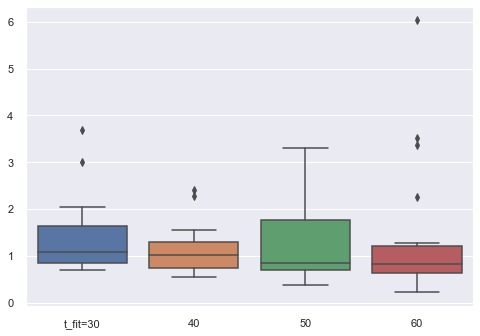

In [37]:
df_fit_f

ls_fit = df_fit_f.to_numpy()

t = ['t_fit=30',40,50,60]
df_fit = pd.DataFrame(ls_fit, columns=t, index=target_states_all)
ax = sns.boxplot(data=df_fit)
df_fit.to_csv('Résultats/df_fit.csv', ',')
print("RMSPE on interval [0;t0]")
df_fit